In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm, trange
import seaborn as sns
from PIL import Image
from scipy.stats import gaussian_kde
# from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from cellpose.io import imread
import pandas as pd
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from kneed import KneeLocator

# Проверка наличия видеокарты

In [2]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

"nvcc" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


>>> GPU activated? NO


"nvidia-smi" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [11]:
from cellpose import io, models
io.logger_setup()

creating new log file
2025-05-23 16:49:40,750 [INFO] WRITING LOG OUTPUT TO C:\Users\gorod\.cellpose\run.log
2025-05-23 16:49:40,751 [INFO] 
cellpose version: 	3.0.10 
platform:       	win32 
python version: 	3.8.19 
torch version:  	2.3.1+cpu


(<Logger cellpose.io (INFO)>, WindowsPath('C:/Users/gorod/.cellpose/run.log'))

# Функции для анализа и отображения распределений

In [8]:
def get_patient_file_paths(path, ftype='.tif'):
    return [os.path.join(path, file) for file in os.listdir(path) if ftype in file]


# def filter_data(data, percent=0.01): эта функция иногда дает ошибку (разное количество в выборках), ниже дипсик исправил
#     # Определяем границы квантилей
#     lower_quantile = percent/2  # Нижний квантиль
#     upper_quantile = 1 - percent/2  # Верхний квантиль

#     # Рассчитаем значения квантилей
#     lower_threshold = np.quantile(data, lower_quantile)  # Квантиль percent/2
#     upper_threshold = np.quantile(data, upper_quantile)  # Квантиль 1-percent/2

#     # Отфильтруем точки, принадлежащие квантилю percent/2 – 1-percent/2
#     filtered_data = data[(data >= lower_threshold) & (data <= upper_threshold)]
#     return filtered_data


def filter_data(data, percent=0.01):
    if len(data) == 0:
        return data.copy()
    
    # Сортируем данные для точного расчета
    sorted_data = np.sort(data)
    n = len(sorted_data)
    
    # Рассчитываем индексы границ
    lower_index = int(np.floor(percent/2 * n))
    upper_index = int(np.ceil((1 - percent/2) * n)) - 1
    
    # Корректируем индексы, чтобы они не выходили за границы массива
    lower_index = max(0, lower_index)
    upper_index = min(n - 1, upper_index)
    
    # Отбираем данные по индексам
    filtered_data = sorted_data[lower_index:upper_index + 1]
    return filtered_data


def analyse_patient(files, model, scale=1/14.4, percent=0.01):
    widths = []
    lengths = []
    areas = []
    EI = []
    DI = []

    for file in files:
        # обработка изображений
        img = imread(file)
        masks, flows, styles = model.eval(img, diameter=105, channels=[0,0])
        masks = masks[10:-10, 10:-10]
        masks = utils.remove_edge_masks(masks, change_index=True)

        # нахождение контуров
        for i in range(1, masks.max()+1):
            mask = masks.copy()
            mask[mask != i] = 0
            mask[mask == i] = 1
            mask = np.array(mask, np.uint8)
            contour, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #находим контуры
            cnt = contour[0]
            try:
                ellipse = cv2.fitEllipse(cnt) # проверка, достаточно ли точек
            except Exception:
                # cell_count -= 1
                continue
            L = max(ellipse[1]) * scale
            W = min(ellipse[1]) * scale
            if W <= 0:
                continue
            areas.append(cv2.contourArea(cnt) * scale**2)
            lengths.append(L)
            widths.append(W)
            EI.append(L/W)
            DI.append((L-W)/(L+W))
    # фильтруем клетки, которые редко попадаются
    if percent > 0:
        lengths = filter_data(np.array(lengths), percent=percent)
        areas = filter_data(np.array(areas), percent=percent)
        EI = filter_data(np.array(EI), percent=percent)
        DI = filter_data(np.array(DI), percent=percent)
    else:
        lengths = np.array(lengths)
        areas = np.array(areas)
        EI = np.array(EI)
        DI = np.array(DI)
    DI_mean = np.mean(DI)
    DI_std = np.std(DI)
    DI_w = fwhm(*kde_plot(DI))
    DI_BC = bimodality_coefficient(DI)
    DI_KC = calc_silhouette_score(DI)
    cell_count = len(lengths)
    return cell_count, lengths, areas, EI, DI, DI_mean, DI_std, DI_w, DI_BC, DI_KC


def draw_data(data, bw_scale=1, points=10000, color=None):
    # calculate the optimal bandwidth using Silverman's rule
    std_dev = np.std(data)
    bandwidth = 1.06 * std_dev * len(data) ** (-1/5) * bw_scale

    plot_x = np.linspace(np.min(data), np.max(data), points)
    kde = gaussian_kde(data, bw_method=bandwidth/std_dev)
    pdf = kde.pdf(plot_x)
    if not color==None:
        plt.plot(plot_x, pdf, color=color)
    else:
        plt.plot(plot_x, pdf)


def kde_plot(data, bw_scale=1, points=10000):
    std_dev = np.std(data)
    bandwidth = 1.06 * std_dev * len(data) ** (-1/5) * bw_scale

    plot_x = np.linspace(np.min(data), np.max(data), points)
    kde = gaussian_kde(data, bw_method=bandwidth/std_dev)
    pdf = kde.pdf(plot_x)
    return plot_x, pdf


def fwhm(x, y):
    max_y = np.max(y)  # Значение максимума
    half_max = max_y / 2  # Половина от максимума

    # Находим индексы, где функция пересекает половину максимума
    indices = np.where(y >= half_max)[0]  # Все индексы, где y >= half_max
    x_left = x[indices[0]]  # Первая точка пересечения (левая граница)
    x_right = x[indices[-1]]  # Последняя точка пересечения (правая граница)

    # Вычисляем FWHM
    fwhm = abs(x_right - x_left)
    return fwhm


def bimodality_coefficient(data):
    """
    Рассчитывает коэффициент унимодальности/бимодальности (Bimodality Coefficient, BC).

    Для унимодальных распределений BC < 0.55, для бимодальных — BC >= 0.55.

    Параметры:
        data (array-like): Набор значений случайной величины.

    Возвращает:
        float: Коэффициент бимодальности.
    """
    # Размер выборки
    n = len(data)

    # Коэффициенты асимметрии и эксцесса
    gamma = skew(data)  # Асимметрия
    kappa = kurtosis(data, fisher=True)  # Эксцесс (Fisher: относительно нормального распределения)

    # Коэффициент бимодальности
    bc = (gamma**2 + 1) / (kappa + 3 * ((n - 1)**2) / ((n - 2) * (n - 3)))

    return bc


def calc_silhouette_score(data):
    kmeans = KMeans(n_clusters=2, random_state=42)
    return silhouette_score(data.reshape(-1,1), kmeans.fit_predict(data.reshape(-1,1)))


def analyse_files(data, model, percent=0.01, save_intermediate_calculations=True, calculations_name=None, make_summary=True, summary_name=None):
    database = {}
    data_traces = {}

    for measurement, path in tqdm(data.items()):
        file_paths = get_patient_file_paths(path, ftype='.png')
        cell_count, lengths, areas, EI, DI, DI_mean, DI_std, DI_w, DI_BC, DI_KC = analyse_patient(file_paths, model, percent=percent)
        database[measurement] = {}
        database[measurement]["cell_count"] = int(cell_count)
        database[measurement]["length_mean"] = np.mean(lengths)
        database[measurement]["area_mean"] = np.mean(areas)
        database[measurement]["EI_mean"] = np.mean(EI)
        database[measurement]["DI_mean"] = DI_mean
        database[measurement]["DI_std"] = DI_std
        database[measurement]["DI_w"] = DI_w
        database[measurement]["DI_BC"] = DI_BC
        database[measurement]["DI_KC"] = DI_KC
    
        data_traces[measurement] = {}
        data_traces[measurement]["lengths"] = lengths
        data_traces[measurement]["areas"] = areas
        data_traces[measurement]["EI"] = EI
        data_traces[measurement]["DI"] = DI

    database_pd = pd.DataFrame.from_dict(database)
    print(database_pd)

    if save_intermediate_calculations:
        if calculations_name == None:
            print('Введете название (calculations_name)')
        
        dataframes = []

        for measurement_name, measurement_data in data_traces.items():
            df = pd.DataFrame(measurement_data)
            df.insert(0, "measurement", measurement_name)
            dataframes.append(df)

        result_df = pd.concat(dataframes, ignore_index=True)

        result_df.to_excel(f'{calculations_name}.xlsx', index=False)
            
    
    if make_summary:
        if summary_name == None:
            print('Введете название (summary_name)')
        database_pd.to_excel(f'{summary_name}.xlsx', index=True)
    
    return database, data_traces


def draw_graphs(data_traces, legend=None, show=True):
    titles = {"lengths" : "длина (мкм)", "areas" : "площадь (ммк^2)", "EI" : "EI_old", "DI" : "DI"}

    for trace_type in ["lengths", "areas", 'EI', "DI"]:
        for measurement in data_traces.keys():
            draw_data(data_traces[measurement][trace_type])
        plt.title(f'График распределения по параметру {titles[trace_type]}')
        plt.xlabel(titles[trace_type])
        plt.ylabel('Плотность вероятности')
        if legend == None:
            plt.legend([f"№{i+1} (среднее {np.mean(data_traces[list(data_traces.keys())[i]][trace_type]):.2f})" for i in range(len(data_traces.keys()))])
        else:
            plt.legend([f"{legend[i]} (среднее {np.mean(data_traces[list(data_traces.keys())[i]][trace_type]):.2f})" for i in range(len(data_traces.keys()))])
        if show:
            plt.show()


def load_traces(file):
    df = pd.read_excel(file)
    data_traces = {}

    for measurement_name, group in df.groupby("measurement"):
        measurement_data = group.drop(columns="measurement").to_dict(orient="list")
        for key, value in measurement_data.items():
            measurement_data[key] = np.array(value)
        data_traces[measurement_name] = measurement_data

    return data_traces

In [12]:
model_path = r'E:\Flow chamber analysis\2025-02-13 Cellpose train\Models\models\deform_2025_02_ep5000_lr0_1_SGD'
model = models.CellposeModel(gpu=True, pretrained_model=model_path, nchan=2)

2025-04-08 21:55:01,307 [INFO] TORCH CUDA version not installed/working.
2025-04-08 21:55:01,309 [INFO] >>>> using CPU
2025-04-08 21:55:01,509 [INFO] >>>> loading model E:\Flow chamber analysis\2025-02-13 Cellpose train\Models\models\deform_2025_02_ep5000_lr0_1_SGD
2025-04-08 21:55:02,341 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2025-04-08 21:55:02,343 [INFO] >>>> model diam_labels =  102.889 (mean diameter of training ROIs)


# Функции для боксплотов

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from matplotlib.patches import FancyArrowPatch, Rectangle, ConnectionStyle
import pandas as pd
from matplotlib.path import Path
import matplotlib.patheffects as PathEffects

def ttest(sample1, sample2, difference_percent):
    # Преобразуем в массивы numpy, если они еще не являются таковыми
    sample1_array = np.array(sample1)
    sample2_array = np.array(sample2)
    
    # Проверка на NaN значения
    sample1_array = sample1_array[~np.isnan(sample1_array)]
    sample2_array = sample2_array[~np.isnan(sample2_array)]
    
    if len(sample1_array) == 0 or len(sample2_array) == 0:
        print('Error: массивые заполнены nan')
        return

    # считаем среднее
    sample1_mean = np.mean(sample1_array)
    sample2_mean = np.mean(sample2_array)

    # рассчитываем смещение
    if difference_percent > 0:
        max_diff = np.mean((sample1_mean, sample2_mean)) * (difference_percent) / 100
        delta = max_diff if sample1_mean < sample2_mean else -max_diff
    else:
        delta = 0
    
    u_stat, p_value = stats.ttest_ind(sample1_array, sample2_array + delta, alternative='greater', equal_var=False)
    return u_stat, p_value

def plot_boxplots_with_ttest_percent(data_traces, parameter, pairs_to_compare=None, difference_percent=10, sample_names=None, figsize=(12, 8), alpha=0.05):
    """
    Создает боксплоты для выбранного параметра для каждого измерения с аннотациями
    статистической значимости по тесту Стьюдента.
    
    Parameters:
    -----------
    data_traces : dict
        Словарь, где ключи - это идентификаторы образцов, а значения - словари с параметрами.
        Каждый параметр (lengths, areas, EI, DI и т.д.) - это список значений.
    parameter : str
        Название параметра для визуализации (например, 'lengths', 'areas', 'EI').
    figsize : tuple, optional
        Размер графика (ширина, высота) в дюймах.
    alpha : float, optional
        Уровень значимости для теста Стьюдента (по умолчанию 0.05).
    
    Returns:
    --------
    fig, ax : tuple
        Объекты matplotlib для дальнейшей настройки графика при необходимости.
    """
    
    # Извлечем данные для выбранного параметра
    if sample_names==None:
        sample_names = list(data_traces.keys())
    
    # Проверяем существование параметра в каждом образце и преобразуем в списки
    data_for_boxplot = []
    valid_sample_names = []
    
    for sample in sample_names:
        if parameter in data_traces[sample] and data_traces[sample][parameter] is not None:
            # Преобразуем в список, если данные в numpy массиве
            data = data_traces[sample][parameter]
            if isinstance(data, np.ndarray):
                data = data.tolist()
            
            # Проверяем, что данные не пустые
            if len(data) > 0:
                data_for_boxplot.append(data)
                valid_sample_names.append(sample)
    
    # Проверяем, есть ли данные для построения
    if not data_for_boxplot:
        raise ValueError(f"Нет данных для параметра '{parameter}' ни в одном из образцов")
    
    # Создаем фигуру и оси
    fig, ax = plt.subplots(figsize=figsize)
    
    # Строим боксплоты (используем tick_labels вместо labels)
    bp = ax.boxplot(data_for_boxplot, patch_artist=True, showfliers=False, showmeans=True, labels=valid_sample_names)
    
    # Настраиваем цвета боксплотов
    colors = plt.cm.plasma(np.linspace(0, 1, len(valid_sample_names)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)
    
    # Добавляем точки данных
    for i, data in enumerate(data_for_boxplot):
        # Добавляем небольшой шум по оси x для лучшей визуализации
        x = np.random.normal(i+1, 0.04, size=len(data))
        ax.scatter(x, data, s=2, c='black', alpha=0.3)
    
    # Настройка графика
    ax.set_title(f'Распределение параметра "{parameter}" по образцам', fontsize=14)
    ax.set_xlabel('Образец', fontsize=12)
    ax.set_ylabel(parameter, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Находим минимальное и максимальное значения для всех данных
    all_values = [val for sublist in data_for_boxplot for val in sublist]
    if not all_values:
        raise ValueError(f"Нет данных для параметра '{parameter}'")
    
    y_max = max(all_values) * 1.1
    y_min = min(all_values)
    y_range = y_max - y_min
    
    # Проводим тесты Стьюдента и собираем значимые результаты
    n_samples = len(valid_sample_names)
    significant_pairs = []

    if pairs_to_compare == None:
        for i in range(n_samples - 1):
            for j in range(i + 1, n_samples):
                # Проводим тест Стьюдента
                sample1 = data_for_boxplot[i]
                sample2 = data_for_boxplot[j]

                # Проверяем, что данные не пустые
                if not sample1 or not sample2:
                    continue

                u_stat, p_value = ttest(sample1, sample2, difference_percent)
                
                # Если p-значение меньше alpha, добавляем пару в список значимых результатов
                if p_value < alpha:
                    significant_pairs.append((i, j, p_value))
    else:
        for name_i, name_j in pairs_to_compare:
            i = valid_sample_names.index(name_i)
            j = valid_sample_names.index(name_j)

            sample1 = data_for_boxplot[i]
            sample2 = data_for_boxplot[j]

            # Проверяем, что данные не пустые
            if not sample1 or not sample2:
                continue

            u_stat, p_value = ttest(sample1, sample2, difference_percent)
            significant_pairs.append((i, j, p_value))
            
    
    # Сортируем пары по расстоянию между образцами (сначала ближайшие)
    significant_pairs.sort(key=lambda x: x[1] - x[0])
    
    # Определяем высоту для каждой аннотации
    height_step = y_range * 0.05 # Было 0.07
    
    # Структура для отслеживания занятых интервалов
    # Каждый элемент - это кортеж (x_start, x_end, height)
    occupied_intervals = []
    
    # Функция для проверки пересечения интервалов
    def intervals_overlap(interval1, interval2):
        # Проверяет, пересекаются ли два интервала
        a_start, a_end = interval1
        b_start, b_end = interval2
        return max(a_start, b_start) <= min(a_end, b_end)
    
    # Функция для определения высоты аннотации
    def get_annotation_height(x_start, x_end):
        # Начнем с минимальной высоты
        height = y_max + height_step
        
        # Проверим все занятые интервалы
        while True:
            # Найдем все интервалы, которые пересекаются с нашим на текущей высоте
            overlapping = [h for x1, x2, h in occupied_intervals 
                          if h == height and intervals_overlap((x_start, x_end), (x1, x2))]
            
            if not overlapping:
                # Если нет пересечений, используем эту высоту
                return height
            else:
                # Иначе пробуем следующий уровень
                height += height_step
    
    # Добавляем аннотации для значимых пар
    for i, j, p_value in significant_pairs:
        # Определяем интервал по оси X
        x_start = i + 1  # +1 потому что индексы боксплотов начинаются с 1
        x_end = j + 1
        
        # Находим подходящую высоту для аннотации
        height = get_annotation_height(x_start, x_end)
        
        # Добавляем интервал в список занятых
        occupied_intervals.append((x_start, x_end, height))
        
        # Рисуем горизонтальную линию
        ax.plot([x_start, x_end], [height, height], 'k-', lw=1.5)
        
        # Добавляем вертикальные линии (усы) только снизу
        bar_length = height_step * 0.2  # Длина уса
        ax.plot([x_start, x_start], [height, height - bar_length], 'k-', lw=1.5)
        ax.plot([x_end, x_end], [height, height - bar_length], 'k-', lw=1.5)
        
        # Добавляем прямоугольник с p-значением
        p_text = f"* (p = {p_value:.3e})" if p_value < 0.001 else f"p = {p_value:.3f})"
        rx, ry = (x_start + x_end) / 2, height + height_step * 0.3
        # rect = Rectangle((rx - 0.4, ry - height_step * 0.25), 0.8, height_step * 0.5, 
                        # facecolor='white', edgecolor='black', alpha=0.8)
        # ax.add_patch(rect)
        ax.text(rx, ry, p_text, ha='center', va='center', fontsize=8)
    
    # Устанавливаем пределы оси y с учетом аннотаций
    if occupied_intervals:
        max_height = max([h for _, _, h in occupied_intervals])
        ax.set_ylim(ax.get_ylim()[0], max_height + height_step * 2)
    
    plt.tight_layout()
    return fig, ax

In [ ]:
# пример

fig, ax = plot_boxplots_with_ttest_percent(
    data_traces,
    'DI',
    pairs_to_compare=[['0%', '50%']],
    difference_percent=1,
    sample_names=['0%', '1%', '10%', '50%', '100%']
)
plt.show()

# Функции для EM-алгоритма

In [34]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, argrelextrema
from scipy.optimize import curve_fit, minimize
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from kneed import KneeLocator
import seaborn as sns

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2)

def multi_gaussian(x, *params):
    """Функция для суммы нескольких гауссовых распределений"""
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        amplitude, mean, stddev = params[i:i+3]
        y += gaussian(x, amplitude, mean, stddev)
    return y

def find_peaks_and_fit(data_original, EM=True, optimise=True, n_components=None, n_as_max=False, min_components=1, max_components=10, 
                  weight_threshold=0.01, penalty_factor=0.01, random_state=42, means_init=None):
    """
    Анализирует распределение на наличие пиков с помощью EM-алгоритма.
    
    Параметры:
    ----------
    data : array-like
        Одномерный массив данных для анализа.
    n_components : int, optional
        Количество компонент для модели. Если None, будет подобрано автоматически.
    min_components : int, default=1
        Минимальное количество компонент для автоматического подбора.
    max_components : int, default=10
        Максимальное количество компонент для автоматического подбора.
    weight_threshold : float, default=0.01
        Порог веса компоненты для её учёта.
    penalty_factor : float, default=0.01
        Фактор штрафа за большое количество компонент.
    random_state : int, default=42
        Случайное зерно для воспроизводимости результатов.
    means_init : array-like, optional
        Начальные средние значения для компонент. Если None, средние будут определены автоматически.
        Должен быть массив формы (n_components,) для n_components компонент.
    
    Возвращает:
    -----------
    DataFrame
        Датафрейм с информацией о пиках: среднее, стандартное отклонение,
        амплитуда и вес.
    """
    if (n_components is not None) and n_as_max:
        print('Error')
        return
    
    x, distribution_kde = kde_plot(data_original)

    if n_as_max or not EM:
        peaks, _ = find_peaks(distribution_kde)
        minima_indices = argrelextrema(distribution_kde, np.less)[0]

        peak_data = []
    
        # Находим начальные параметры каждого пика
        for peak in peaks:
            left_min = minima_indices[minima_indices < peak][-1] if minima_indices[minima_indices < peak].size > 0 else 0
            right_min = minima_indices[minima_indices > peak][0] if minima_indices[minima_indices > peak].size > 0 else len(distribution_kde) - 1
            
            x_fit = x[left_min:right_min + 1]
            y_fit = distribution_kde[left_min:right_min + 1]
            
            initial_guess = [distribution_kde[peak], x[peak], (x[right_min] - x[left_min]) / 4]
            params, _ = curve_fit(gaussian, x_fit, y_fit, p0=initial_guess, maxfev=10000)
            
            amplitude, mean, stddev = params
            weight = np.sum(gaussian(x_fit, amplitude, mean, stddev)) / np.sum(distribution_kde)
    
            if weight > weight_threshold:
                peak_data.append({
                    'mean': mean,
                    'stddev': stddev,
                    'weight': weight,
                    'amplitude': amplitude,
                })
        
        n_components = len(peak_data)
        
        peaks_df = pd.DataFrame(peak_data)

    data = np.array(data_original).reshape(-1, 1)
    
    # Если количество компонент не задано, подбираем автоматически
    if EM:
        if n_components is None:
            bic_scores = []
            n_components_range = range(min_components, max_components + 1)
            
            for n in n_components_range:
                # Используем means_init только если количество совпадает с n_components
                if means_init is not None and len(means_init) == n:
                    current_means_init = np.array(means_init).reshape(n, 1)
                    gmm = GaussianMixture(n_components=n, tol=1e-5, max_iter=10000, 
                                         random_state=random_state, means_init=current_means_init)
                else:
                    gmm = GaussianMixture(n_components=n, tol=1e-5, max_iter=10000, random_state=random_state)
                gmm.fit(data)
                # Добавляем штраф за большое количество компонент
                penalized_bic = gmm.bic(data) + penalty_factor * n * np.log(len(data))
                bic_scores.append(penalized_bic)
            
            # Используем метод локтя для определения оптимального количества компонент
            try:
                knee = KneeLocator(
                    n_components_range, bic_scores, 
                    curve='convex', direction='decreasing'
                )
                optimal_n = knee.elbow
                if optimal_n is None:
                    optimal_n = min_components
            except Exception:
                # Если метод локтя не сработал, берем компоненту с минимальным BIC
                optimal_n = n_components_range[np.argmin(bic_scores)]
            
            n_components = optimal_n
        
        # Обучаем GMM с оптимальным количеством компонент
        # Используем means_init, если предоставлены и соответствуют n_components
        if means_init is not None and len(means_init) == n_components:
            means_init_reshaped = np.array(means_init).reshape(n_components, 1)
            gmm = GaussianMixture(n_components=n_components, tol=1e-5, max_iter=10000, 
                                 random_state=random_state, means_init=means_init_reshaped)
        else:
            gmm = GaussianMixture(n_components=n_components, tol=1e-5, max_iter=10000, random_state=random_state)
        gmm.fit(data)
        
        # Извлекаем параметры компонент
        weights = gmm.weights_
        means = gmm.means_.flatten()
        stddevs = np.sqrt(gmm.covariances_.flatten())
        
        # Создаем датафрейм с параметрами компонент
        peaks_df = pd.DataFrame({
            'mean': means,
            'stddev': stddevs,
            'weight': weights,
            'amplitude': weights / (stddevs * np.sqrt(2 * np.pi))
        })
    
        # Сортируем по средним значениям
        peaks_df = peaks_df.sort_values('mean').reset_index(drop=True)
    
        # Фильтруем компоненты по порогу веса
        significant_peaks = peaks_df[peaks_df['weight'] >= weight_threshold].copy()
    
        if len(significant_peaks) == 0:
            # Если нет значимых пиков, возвращаем самый большой
            significant_peaks = peaks_df.sort_values('weight', ascending=False).head(1).copy()
            
        peaks_df = significant_peaks

    if optimise:
        # Подготовим начальные параметры для глобальной оптимизации
        initial_params = []
        for i, peak in peaks_df.iterrows():
            initial_params.extend([peak['amplitude'], peak['mean'], peak['stddev']])
        
        # Определим границы для параметров
        bounds = []
        for i, peak in peaks_df.iterrows():
            # Амплитуда: от 0 до 2*исходной
            bounds.append((0, 2 * peak['amplitude']))
            # Среднее: ±10% от исходного значения
            mean_range = 0.10 * abs(peak['mean'])
            bounds.append((peak['mean'] - mean_range, peak['mean'] + mean_range))
            # Стандартное отклонение: от 0.5*исходного до 2*исходного
            bounds.append((0.5 * peak['stddev'], 2 * peak['stddev']))
        
        # Функция ошибки для минимизации
        def error_function(params):
            y_pred = multi_gaussian(x, *params)
            return np.sum((distribution_kde - y_pred) ** 2)
        
        # Глобальная оптимизация
        result = minimize(error_function, initial_params, bounds=bounds, method='L-BFGS-B')
        optimized_params = result.x
        
        # Создаем копию DataFrame чтобы избежать предупреждений pandas
        peaks_df = peaks_df.copy()
        
        # Обновим peaks_df с оптимизированными параметрами
        for i in range(len(peaks_df)):
            peaks_df.loc[i, 'amplitude'] = optimized_params[i*3]
            peaks_df.loc[i, 'mean'] = optimized_params[i*3+1]
            peaks_df.loc[i, 'stddev'] = optimized_params[i*3+2]
            
            # Пересчитаем веса с новыми параметрами
            gauss = gaussian(x, peaks_df.loc[i, 'amplitude'], peaks_df.loc[i, 'mean'], peaks_df.loc[i, 'stddev'])
            peaks_df.loc[i, 'weight'] = np.sum(gauss) / np.sum(distribution_kde)
    
    total_weight = sum([row['weight'] for i, row in peaks_df.iterrows()])
    
    # Нормализуем веса, чтобы их сумма была равна 1
    peaks_df['weight'] = peaks_df['weight'] / total_weight
    
    return peaks_df

def plot_distribution_with_peaks(trace, peak_df, parameter, title=None):
    plt.figure(figsize=(10, 6))

    # Гистограмма исходного распределения
    # plt.hist(trace, bins=60, density=True, alpha=0.6, color='g')
    std_dev = np.std(trace)
    bandwidth = 1.06 * std_dev * len(trace) ** (-1/5)
    sns.histplot(trace, stat='density', binwidth=bandwidth, alpha=0.5, color='cornflowerblue', element='step')

    # kde для исходного распределения
    x, distribution = kde_plot(trace)
    plt.plot(x, distribution, label='Original Distribution', color='slateblue')
    
    total_fit = np.zeros_like(distribution)

    height_add = max(distribution)*0.05
    
    for i, row in peak_df.iterrows():
        gauss = gaussian(x, row['amplitude'], row['mean'], row['stddev'])
        total_fit += gauss
        plt.plot(x, gauss, '--', label=f'Peak {i+1}')
        
        label_text = f'Peak {i+1}\nμ={row["mean"]:.2f}\nσ={row["stddev"]:.2f}\nw={row["weight"]:.2f}'
        plt.text(row['mean'], gaussian(row['mean'], row['amplitude'] + height_add, row['mean'], row['stddev']), 
                 label_text, fontsize=9, ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.8))

    plt.ylim(top=max(max(distribution), max(total_fit)) * 1.3)
    
    # Вычисляем ошибку аппроксимации
    mse = np.mean((distribution - total_fit) ** 2)
    
    plt.plot(x, total_fit, label=f'Total Fit (MSE: {mse:.6f})', color='red')
    plt.legend()
    plt.xlabel(parameter)
    plt.ylabel('Плотность вероятности')
    if title==None:
        plt.title('Распределение с Гауссовыми пиками')
    else:
        plt.title(f'Распределение для образца: {title}')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Возвращаем ошибку для возможного анализа
    return mse

def analyse_peaks(data_traces, parameter, sample_names=None, save_name=None, EM=True, optimise=True, n_as_max=False, n_components=None, weight_threshold=0.005, max_components=10, penalty_factor=0.1, means_init=None):
    peaks_weights = pd.DataFrame()
    mse_values = {}

    if sample_names==None:
        sample_names = data_traces.keys()

    for measurement in sample_names:
        peaks_weight_temp = find_peaks_and_fit(data_traces[measurement][parameter], 
                                              EM=EM, 
                                              optimise=optimise, 
                                              n_as_max=n_as_max, 
                                              n_components=n_components, 
                                              weight_threshold=weight_threshold, 
                                              penalty_factor=penalty_factor, 
                                              max_components=max_components,
                                              means_init=means_init)
        mse = plot_distribution_with_peaks(data_traces[measurement][parameter], peaks_weight_temp, parameter, title=measurement)
        mse_values[measurement] = mse
        
        peaks_weight_temp.insert(0, "peak_number", np.arange(1, 1 + len(peaks_weight_temp)))
        peaks_weight_temp.insert(0, "measurement", [measurement] * len(peaks_weight_temp))
        peaks_weights = pd.concat([peaks_weights, peaks_weight_temp], ignore_index=True)

    if not save_name==None:
        peaks_weights.to_excel(f'{save_name}.xlsx', index=False)
    
    print("Средняя квадратичная ошибка для каждого измерения:")
    for measurement, mse in mse_values.items():
        print(f"{measurement}: {mse:.6f}")
    
    print("\nРезультаты анализа пиков:")
    print(peaks_weights)
    
    return peaks_weights

In [ ]:
# пример

analyse_peaks(
    data_traces,
    parameter='DI',
    sample_names = ['0%', '1%', '10%', '50%', '100%'],
    save_name = '2025-03-12 peak weights old',
    n_as_max=True,
    EM=False,
    optimise=True
)

# Еще пример графика

In [ ]:
labels = data.keys()

plt.errorbar(labels, database_pd.loc["length_mean"], yerr = [fwhm(*kde_plot(data_traces[m]['lengths'])) for m in labels], fmt='o--', capsize=7)
plt.ylim(bottom=0)
plt.title("Зависимость длины клетки от номера измерения")
plt.xlabel("Номер измерения")
plt.ylabel("Длина клетки, мкм")
plt.tight_layout()
plt.show()

# Разные концентрации глутара

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:01<00:00, 72.36s/it]


                     0%          1%         10%          50%        100%
cell_count   354.000000  664.000000  845.000000  1017.000000  227.000000
length_mean    8.844810    8.411592    8.600423     8.835275    7.991843
area_mean     46.206289   39.865539   43.144279    47.567709   45.358293
EI_mean        1.323937    1.385090    1.342512     1.282043    1.109692
DI_mean        0.135747    0.157554    0.141260     0.120090    0.050646
DI_std         0.054311    0.057039    0.064288     0.054696    0.034407
DI_w           0.118339    0.146501    0.164471     0.130476    0.055641
DI_BC          0.248188    0.355706    0.365531     0.347093    0.526748
DI_KC          0.527285    0.565336    0.559298     0.545896    0.650957


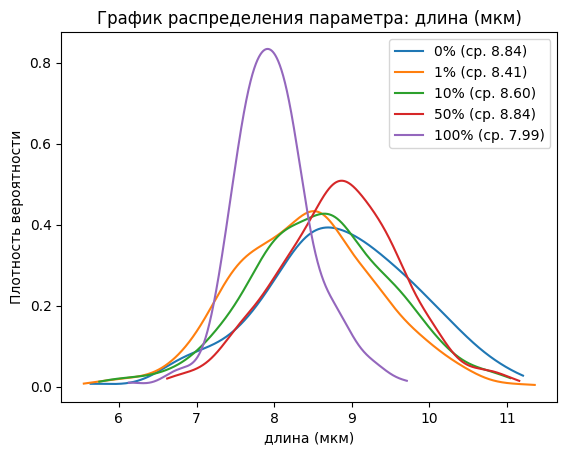

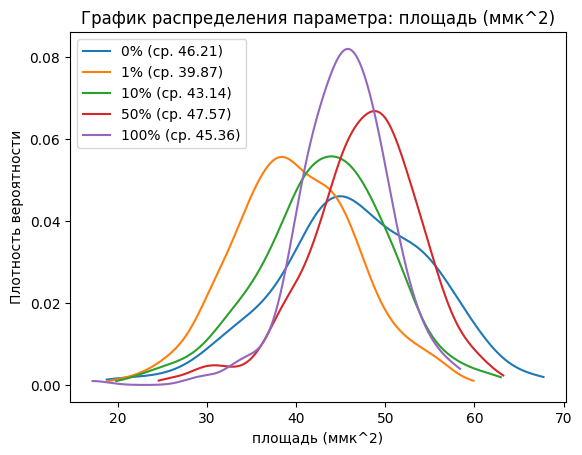

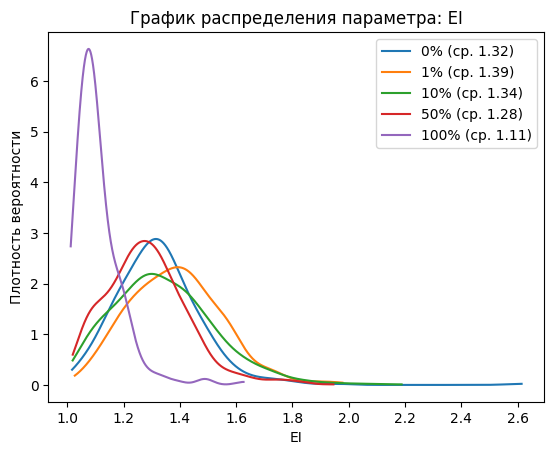

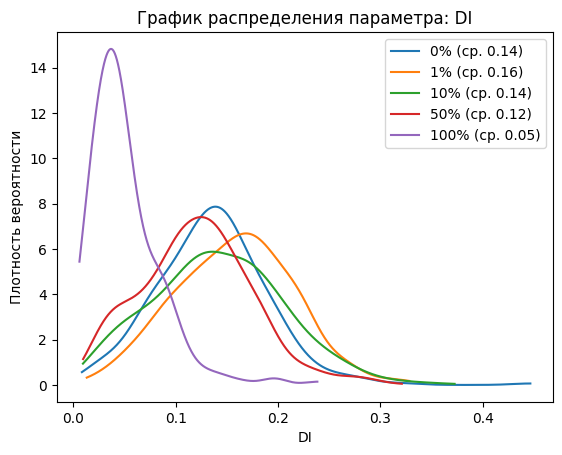

In [11]:
data = {
    "0%" : r"E:\Flow chamber\Ladynin\2025-04-04-flow chamber\0\4",
    "1%" : r"E:\Flow chamber\Ladynin\2025-04-04-flow chamber\1",
    "10%" : r"E:\Flow chamber\Ladynin\2025-04-04-flow chamber\10",
    "50%" : r"E:\Flow chamber\Ladynin\2025-04-04-flow chamber\50",
    "100%" : r"E:\Flow chamber\Ladynin\2025-04-04-flow chamber\100"
}

database, data_traces_gly = analyse_files(
    data,
    model,
    percent=0.01,
    calculations_name='2025-04-08 all (gly)',
    summary_name='2025-04-08 summary (gly)'
)

draw_graphs(
    data_traces_gly,
    legend=list(data.keys())
)

database_gly_pd = pd.DataFrame.from_dict(database)

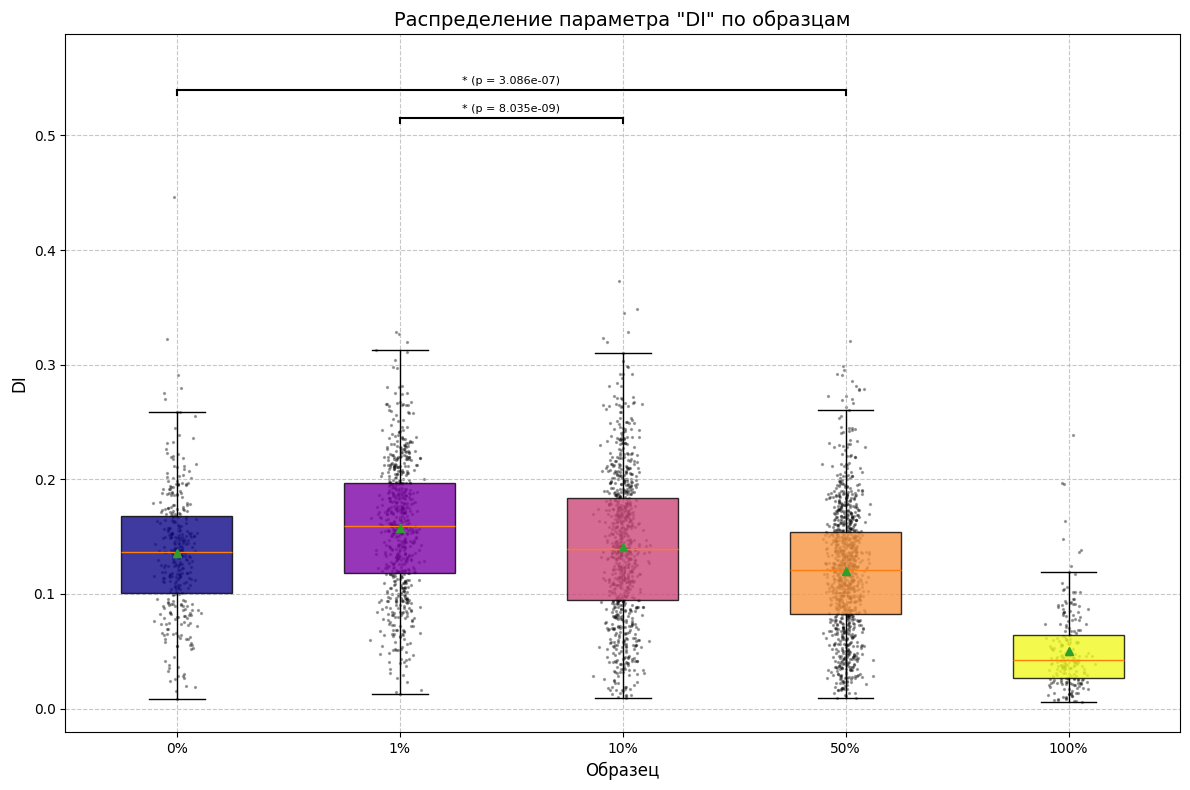

In [48]:
fig, ax = plot_boxplots_with_ttest_percent(
    data_traces_gly,
    'DI',
    pairs_to_compare=[['0%', '50%'], ['1%', '10%']],
    difference_percent=1,
    sample_names=['0%', '1%', '10%', '50%', '100%']
)
plt.show()

In [21]:
data_traces_gly = load_traces(r'E:\Flow chamber analysis\2025-04-08 Glytar analysis 5\2025-04-08 all (gly).xlsx')

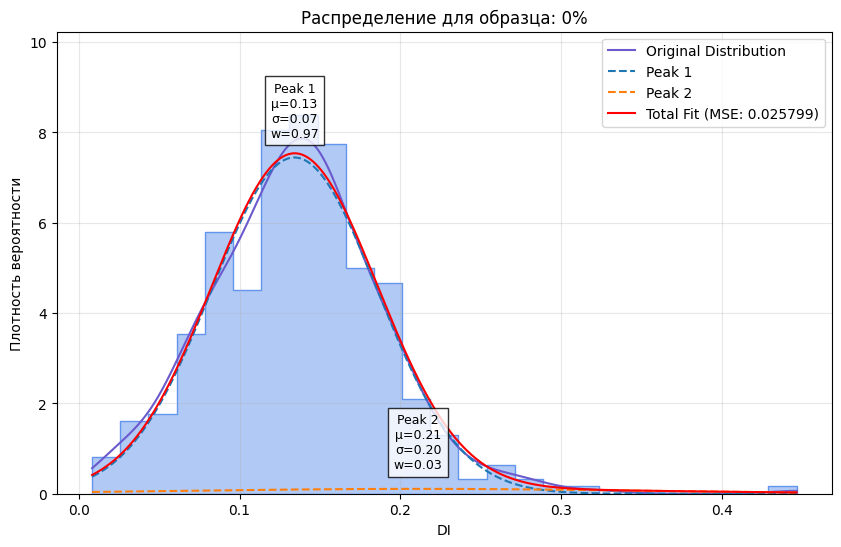

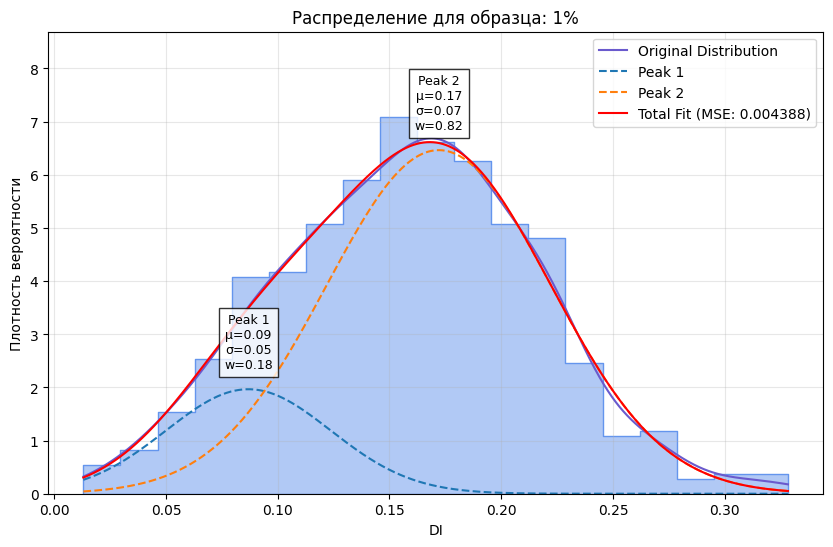

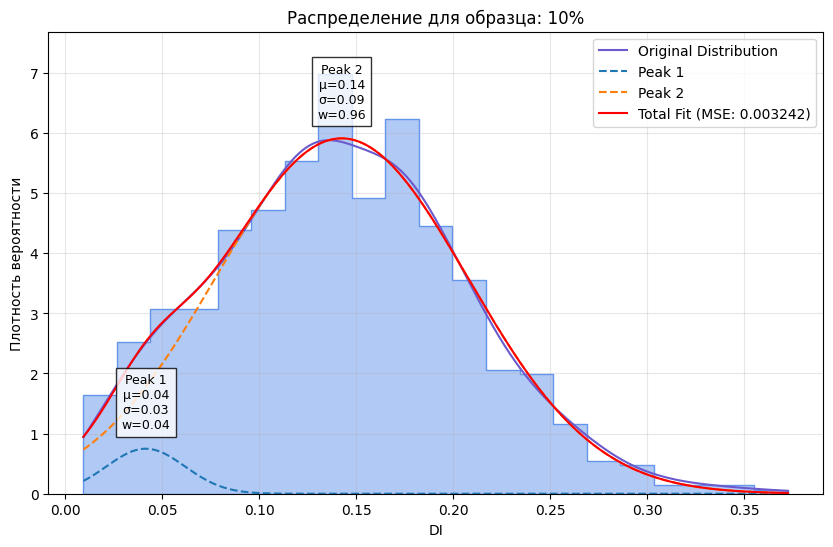

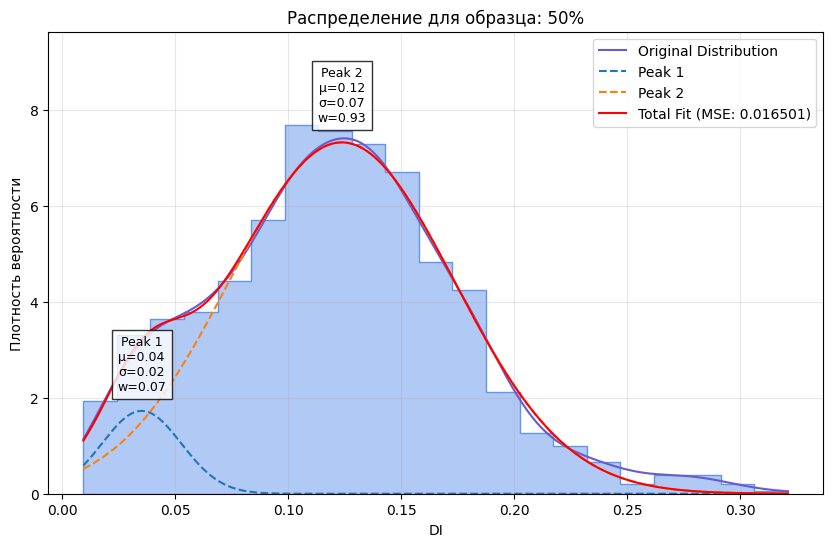

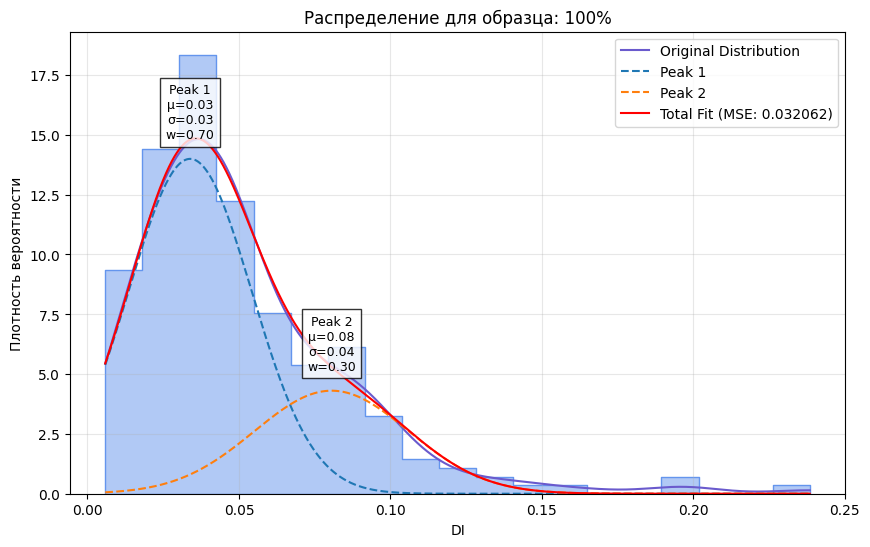

Средняя квадратичная ошибка для каждого измерения:
0%: 0.025799
1%: 0.004388
10%: 0.003242
50%: 0.016501
100%: 0.032062

Результаты анализа пиков:
  measurement  peak_number      mean    stddev    weight  amplitude
0          0%            1  0.134143  0.072873  0.965968   7.440566
1          0%            2  0.211219  0.201765  0.034032   0.107642
2          1%            1  0.086857  0.051990  0.179050   1.965538
3          1%            2  0.172057  0.071000  0.820950   6.463137
4         10%            1  0.041433  0.028642  0.036527   0.748410
5         10%            2  0.142494  0.092229  0.963473   5.908614
6         50%            1  0.035207  0.024819  0.072568   1.725576
7         50%            2  0.123727  0.070220  0.927432   7.319817
8        100%            1  0.033879  0.028669  0.703494  13.997293
9        100%            2  0.080587  0.036055  0.296506   4.306964


measurement  peak_number      mean    stddev    weight  amplitude
0          0%            1  0.134143  0.072873  0.965968   7.440566
1          0%            2  0.211219  0.201765  0.034032   0.107642
2          1%            1  0.086857  0.051990  0.179050   1.965538
3          1%            2  0.172057  0.071000  0.820950   6.463137
4         10%            1  0.041433  0.028642  0.036527   0.748410
5         10%            2  0.142494  0.092229  0.963473   5.908614
6         50%            1  0.035207  0.024819  0.072568   1.725576
7         50%            2  0.123727  0.070220  0.927432   7.319817
8        100%            1  0.033879  0.028669  0.703494  13.997293
9        100%            2  0.080587  0.036055  0.296506   4.306964

In [33]:
# пример

analyse_peaks(
    data_traces_gly,
    parameter='DI',
    sample_names = ['0%', '1%', '10%', '50%', '100%'],
    save_name = '2025-04-08 peak weights',
    # n_as_max=True,
    n_components=2,
    EM=True,
    optimise=True,
    means_init=[0.05, 0.12]
)

# Сравнение PBS и Рингера

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\Users\gorod\anaconda3\envs\cellpose\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 25%|████████████████████                                                            | 1/4 [27:29<1:22:29, 1649.97s/it]C:\Users\gorod\anaconda3\envs\cellpose\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 50%|█████████████████████████████████████████                                         | 2/4 [56:37<56:54, 1707.22s/it]C:\Users\gorod\anaconda3\envs\cellpose\lib\site-packages\sklearn\

                      1            2           3           4
cell_count   951.000000  1368.000000  571.000000  354.000000
length_mean    7.881801     7.196663    7.873882    8.843687
area_mean     35.126602    30.903763   36.802207   46.203510
EI_mean        1.379361     1.310625    1.314199    1.323677
DI_mean        0.155621     0.130996    0.132573    0.135635
DI_std         0.056239     0.054146    0.052130    0.054451
DI_w           0.138931     0.141089    0.134455    0.117812
DI_BC          0.361014     0.395246    0.388039    0.247092
DI_KC          0.558183     0.563929    0.558121    0.528592


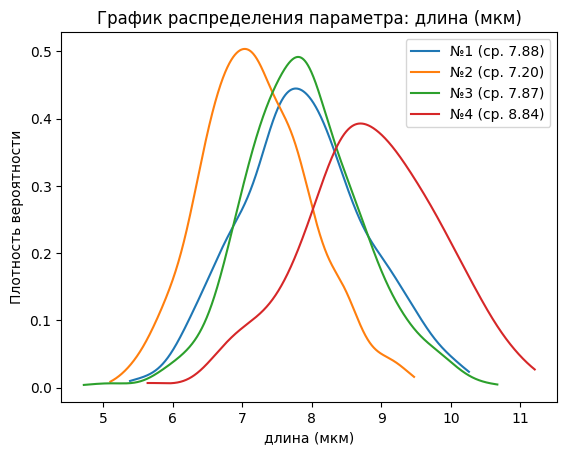

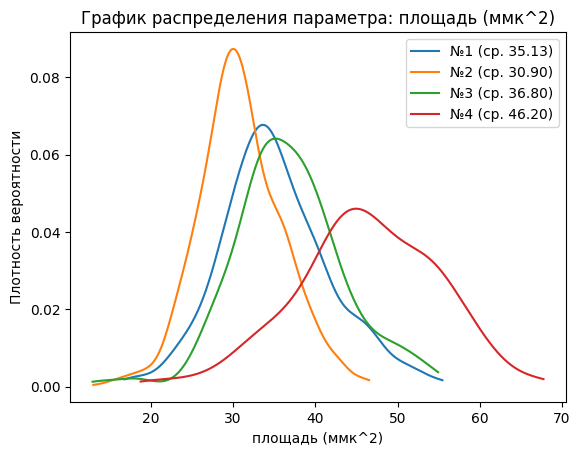

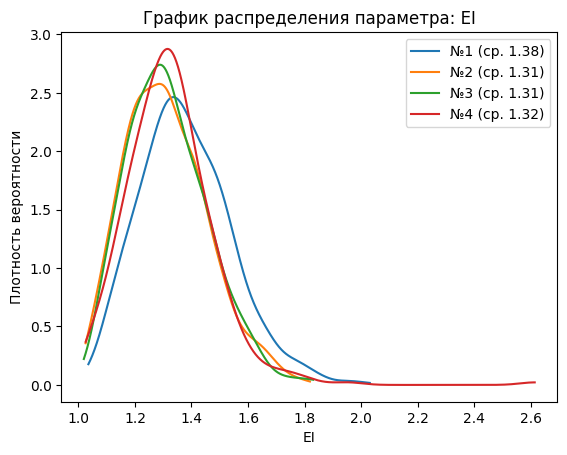

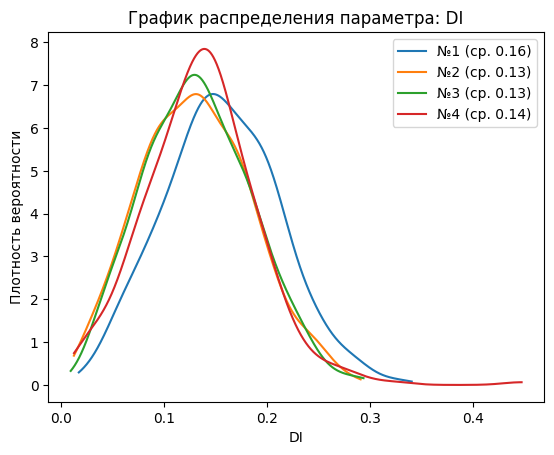

In [35]:
# Ладынин
data = {
    "1" : r"E:\Flow chamber\Ladynin\2025-04-04-flow chamber\0\1",
    "2" : r"E:\Flow chamber\Ladynin\2025-04-04-flow chamber\0\2",
    "3" : r"E:\Flow chamber\Ladynin\2025-04-04-flow chamber\0\3",
    "4" : r"E:\Flow chamber\Ladynin\2025-04-04-flow chamber\0\4"
}

database, data_traces_pbs = analyse_files(
    data,
    model,
    percent=0.01,
    calculations_name='2025-04-08 all (PBS)',
    summary_name='2025-04-08 summary (PBS)'
)

draw_graphs(
    data_traces_pbs
)

database_pbs_pd = pd.DataFrame.from_dict(database)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [09:22<00:00, 140.60s/it]


                       1            2            3           4
cell_count   1919.000000  1605.000000  1955.000000  979.000000
length_mean     9.664758     9.989690     9.783190    9.888464
area_mean      49.600729    52.379640    49.808978   48.968786
EI_mean         1.481655     1.484498     1.496744    1.559401
DI_mean         0.188299     0.189263     0.192516    0.212066
DI_std          0.069303     0.067847     0.071851    0.071295
DI_w            0.131311     0.165602     0.154256    0.131280
DI_BC           0.376417     0.353520     0.347880    0.291203
DI_KC           0.546257     0.567091     0.546998    0.543834


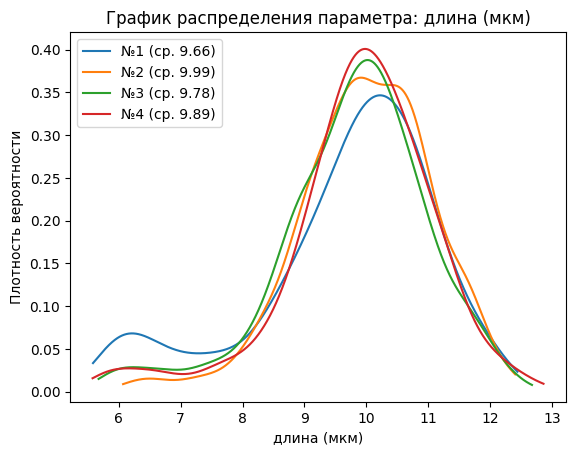

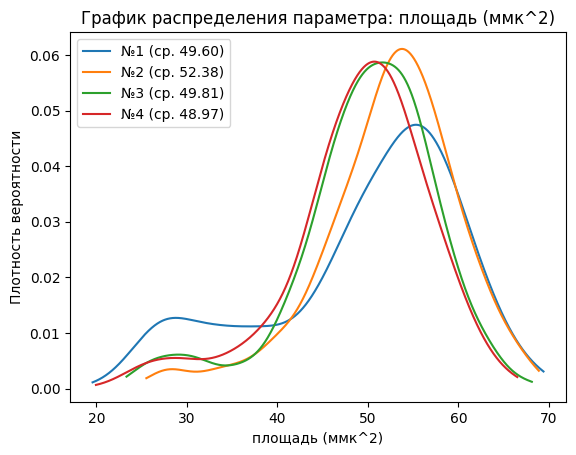

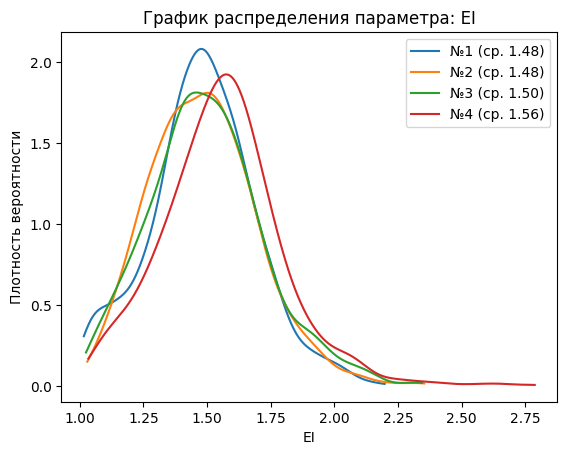

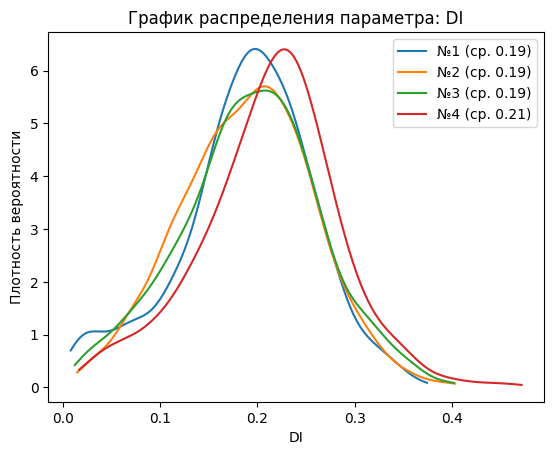

In [27]:
data = {
    "1" : r"E:\Flow chamber\Ladynin\2025-04-04-flow chamber\r1",
    "2" : r"E:\Flow chamber\Ladynin\2025-04-04-flow chamber\r2",
    "3" : r"E:\Flow chamber\Ladynin\2025-04-04-flow chamber\r3",
    "4" : r"E:\Flow chamber\Ladynin\2025-04-04-flow chamber\r4"
}

database, data_traces_ringer = analyse_files(
    data,
    model,
    percent=0.01,
    calculations_name='2025-04-08 all (ringer)',
    summary_name='2025-04-08 summary (ringer)'
)

draw_graphs(
    data_traces_ringer
)

database_ringer_pd = pd.DataFrame.from_dict(database)

In [4]:
data_traces_ringer = load_traces(r'E:\Flow chamber analysis\2025-04-08 Glytar analysis 5\2025-04-08 all (ringer).xlsx')

In [5]:
data_traces_pbs = load_traces(r'E:\Flow chamber analysis\2025-04-08 Glytar analysis 5\2025-04-08 all (pbs).xlsx')

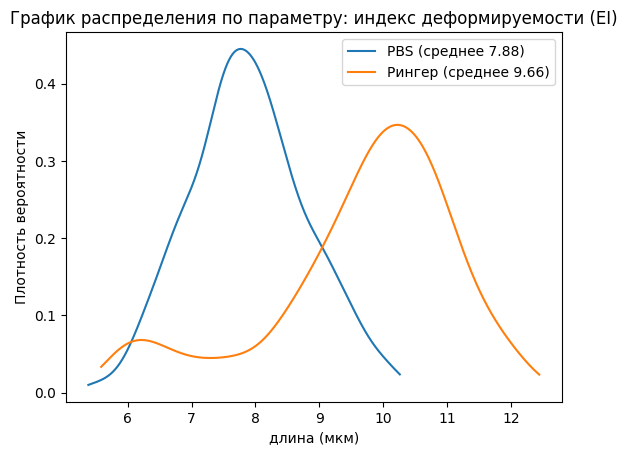

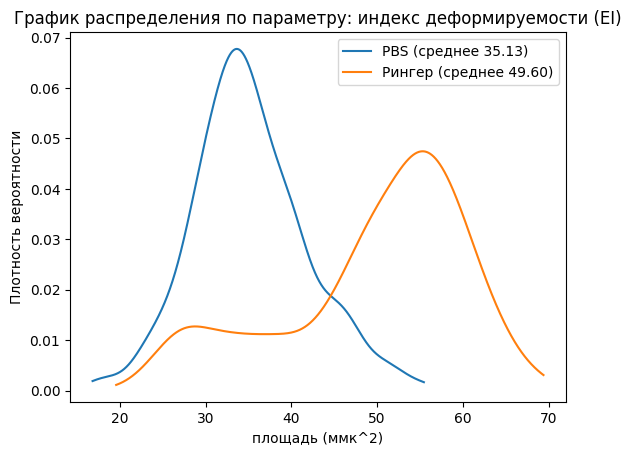

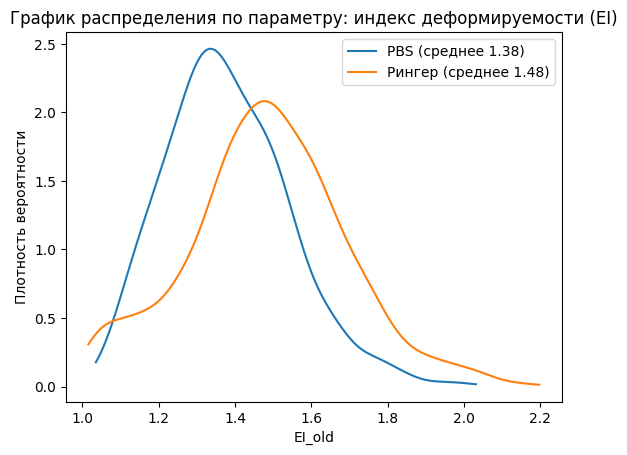

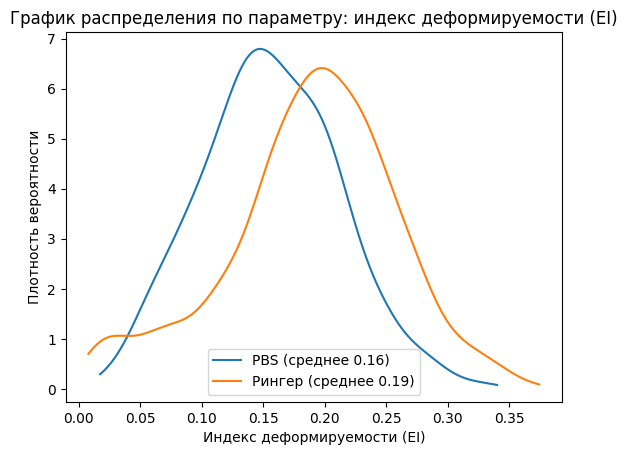

In [9]:
draw_graphs(
    {
        'PBS' : data_traces_pbs[1],
        'Рингер' : data_traces_ringer[1],
    },
    legend = ['PBS', 'Рингер']
)

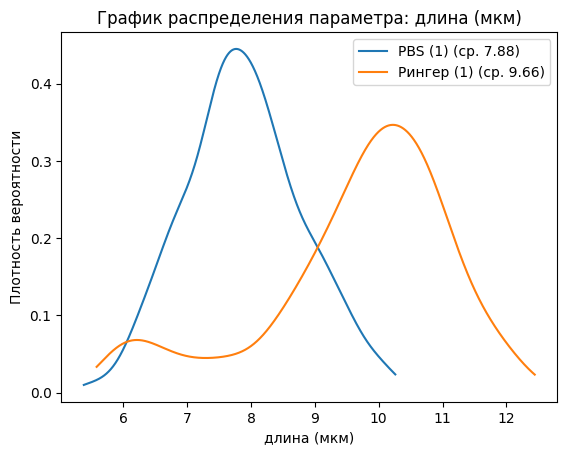

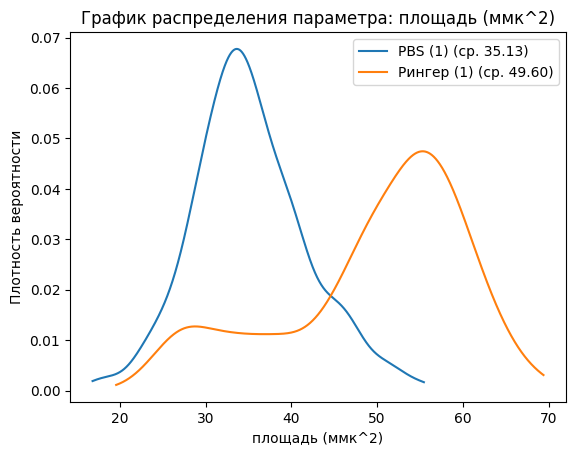

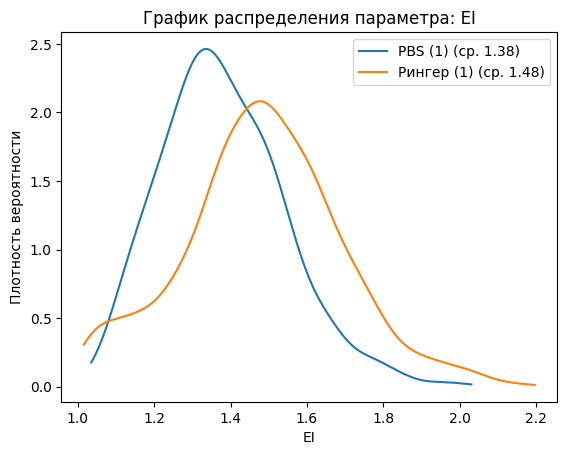

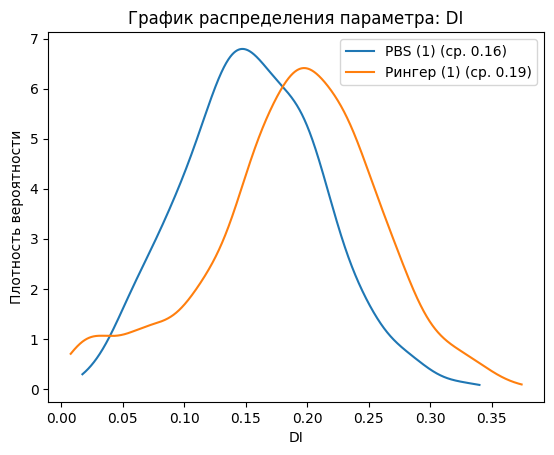

In [45]:
draw_graphs(
    {
        'PBS (1)' : data_traces_pbs['1'],
        'Рингер (1)' : data_traces_ringer[1],
    },
    legend = ['PBS (1)', 'Рингер (1)']
)

In [27]:
database_ringer_pd = pd.read_excel(r'E:\Flow chamber analysis\2025-04-08 Glytar analysis 5\2025-04-08 summary (ringer).xlsx', index_col=0)

In [37]:
database_pbs_pd = pd.read_excel(r'E:\Flow chamber analysis\2025-04-08 Glytar analysis 5\2025-04-08 summary (PBS 3).xlsx', index_col=0)

2025-05-23 17:17:50,364 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 17:17:50,367 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 17:17:50,370 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 17:17:50,377 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


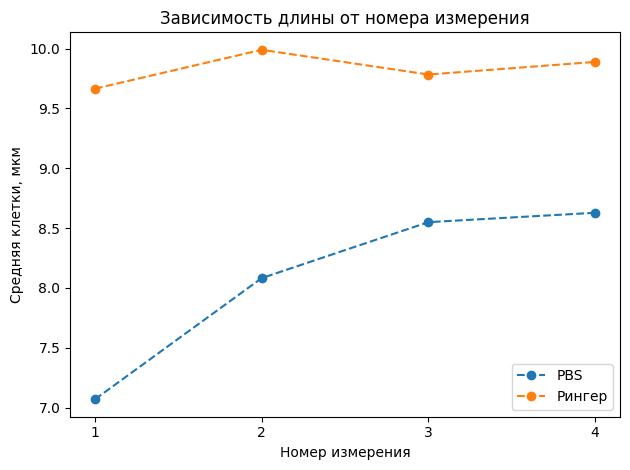

In [40]:
labels = data.keys()

plt.plot(labels, database_pbs_pd.loc["length_mean"], 'o--')
plt.plot(labels, database_ringer_pd.loc["length_mean"], 'o--')
# plt.ylim(bottom=0)
plt.title("Зависимость длины от номера измерения")
plt.xlabel("Номер измерения")
plt.ylabel("Средняя клетки, мкм")
plt.tight_layout()
plt.legend(['PBS', 'Рингер'])
plt.show(
)

2025-05-23 17:17:10,199 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 17:17:10,203 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 17:17:10,207 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 17:17:10,211 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


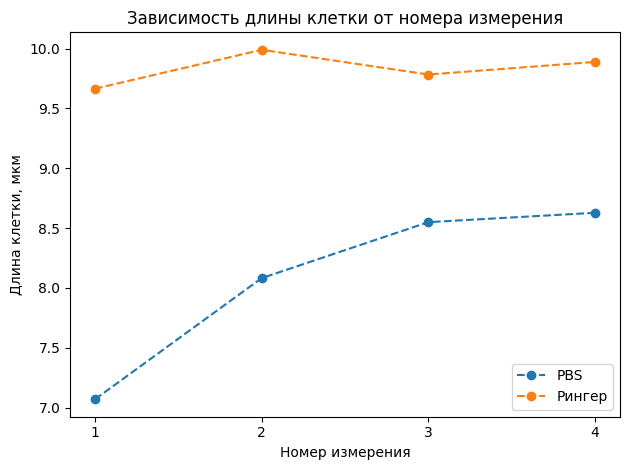

In [38]:
labels = data.keys()

plt.plot(labels, database_pbs_pd.loc["length_mean"], 'o--')
plt.plot(labels, database_ringer_pd.loc["length_mean"], 'o--')
# plt.ylim(bottom=0)
plt.title("Зависимость длины клетки от номера измерения")
plt.xlabel("Номер измерения")
plt.ylabel("Длина клетки, мкм")
plt.tight_layout()
plt.legend(['PBS', 'Рингер'])
plt.show()

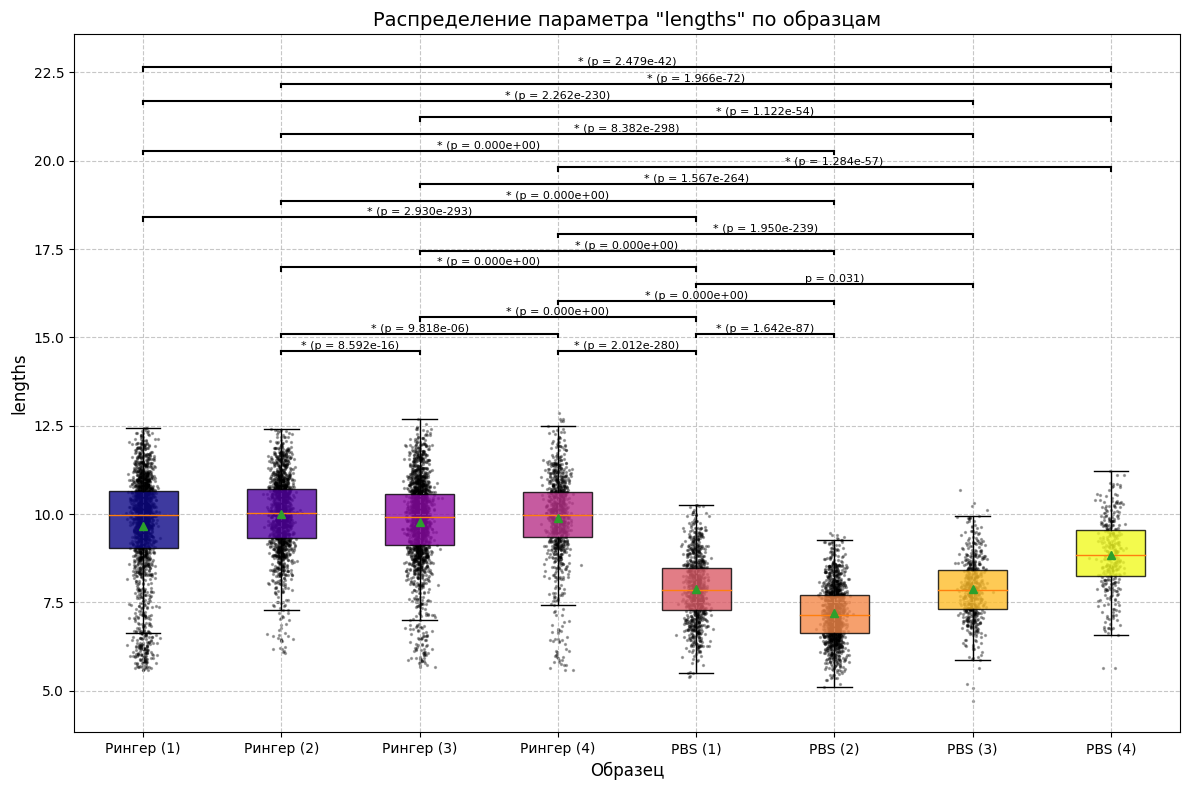

In [83]:
data_traces_pbs_ringer = {}
for i in range(1, 5):
    data_traces_pbs_ringer[f'Рингер ({i})'] = data_traces_ringer[i]
for i in range(1, 5):
    data_traces_pbs_ringer[f'PBS ({i})'] = data_traces_pbs[str(i)]

fig, ax = plot_boxplots_with_ttest_percent(
    data_traces_pbs_ringer,
    'lengths',
    # pairs_to_compare=[['0%', '50%']],
    difference_percent=1,
    sample_names=list(data_traces_pbs_ringer.keys())
)
plt.show()

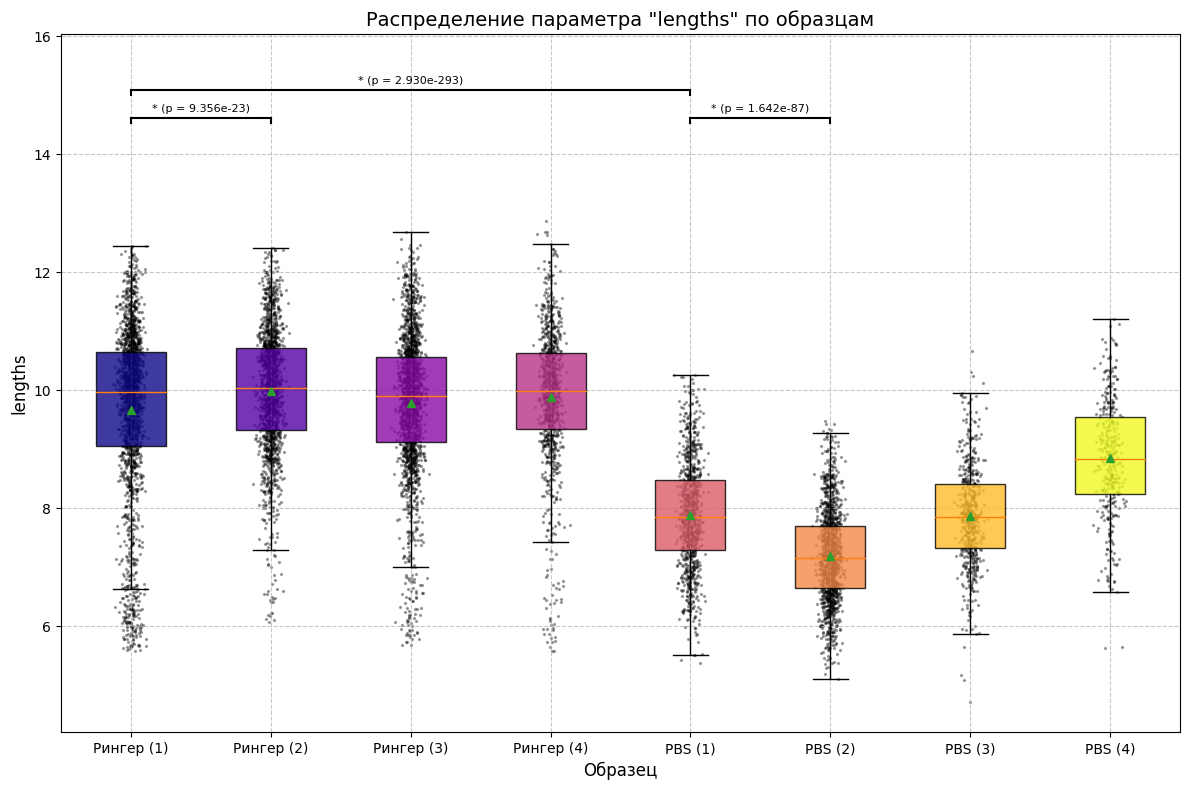

In [103]:
data_traces_pbs_ringer = {}
for i in range(1, 5):
    data_traces_pbs_ringer[f'Рингер ({i})'] = data_traces_ringer[i]
for i in range(1, 5):
    data_traces_pbs_ringer[f'PBS ({i})'] = data_traces_pbs[str(i)]

fig, ax = plot_boxplots_with_ttest_percent(
    data_traces_pbs_ringer,
    'lengths',
    pairs_to_compare=[['Рингер (2)', 'Рингер (1)'], ['Рингер (1)', 'PBS (1)'], ['PBS (1)', 'PBS (2)']],
    difference_percent=1,
    sample_names=list(data_traces_pbs_ringer.keys())
)
plt.show()

2025-04-09 20:50:35,537 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-09 20:50:35,544 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-09 20:50:35,551 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-09 20:50:35,555 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


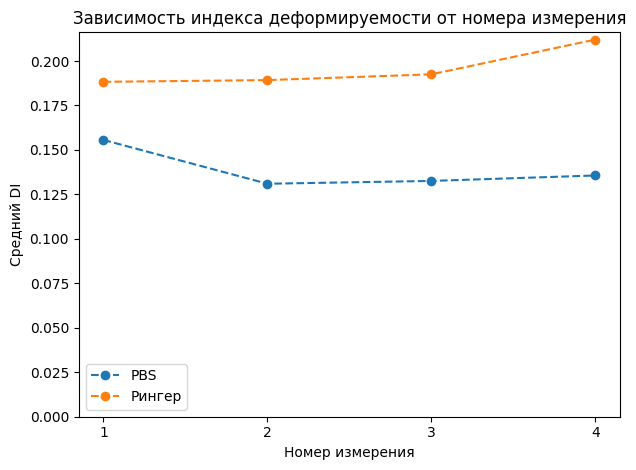

In [57]:
labels = data.keys()

plt.plot(labels, database_pbs_pd.loc["DI_mean"], 'o--')
plt.plot(labels, database_ringer_pd.loc["DI_mean"], 'o--')
plt.ylim(bottom=0)
plt.title("Зависимость индекса деформируемости от номера измерения")
plt.xlabel("Номер измерения")
plt.ylabel("Средний DI")
plt.tight_layout()
plt.legend(['PBS', 'Рингер'])
plt.show()

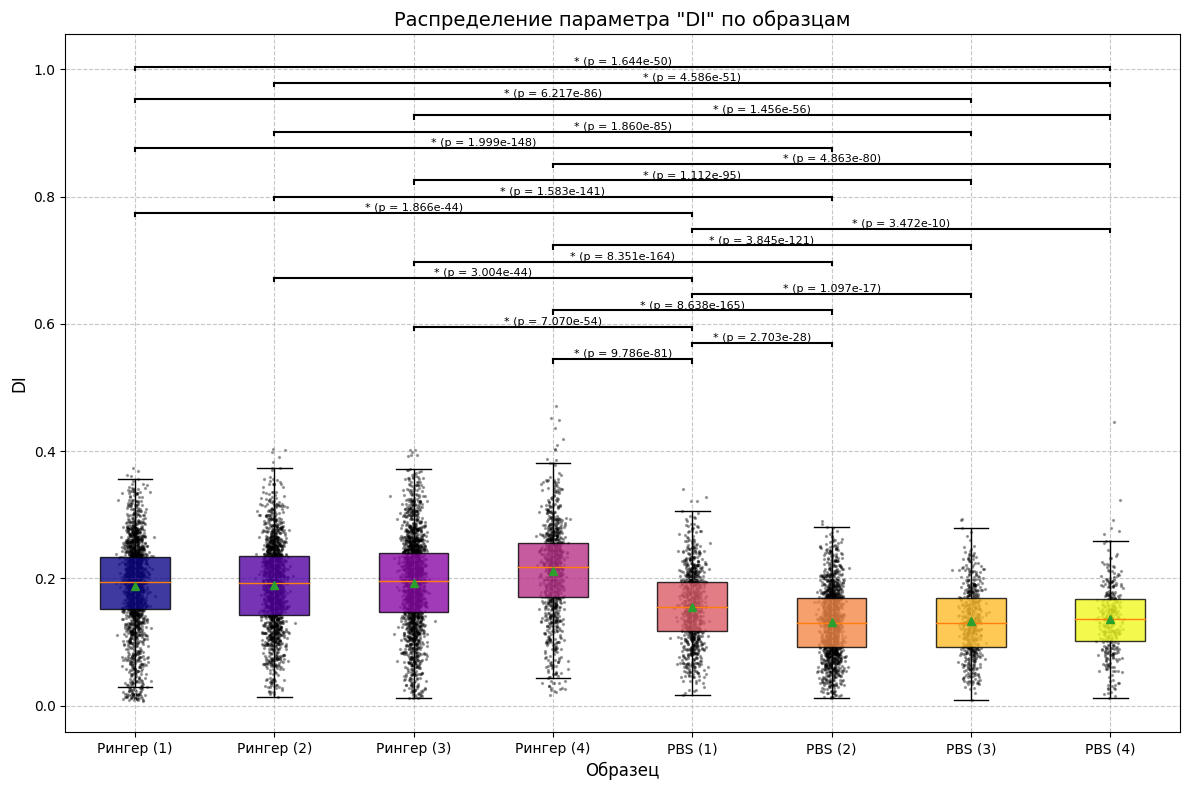

In [68]:
data_traces_pbs_ringer = {}
for i in range(1, 5):
    data_traces_pbs_ringer[f'Рингер ({i})'] = data_traces_ringer[i]
for i in range(1, 5):
    data_traces_pbs_ringer[f'PBS ({i})'] = data_traces_pbs[str(i)]

fig, ax = plot_boxplots_with_ttest_percent(
    data_traces_pbs_ringer,
    'DI',
    # pairs_to_compare=[['PBS (1)', 'Ринге ()']],
    difference_percent=1,
    sample_names=list(data_traces_pbs_ringer.keys())
)
plt.show()

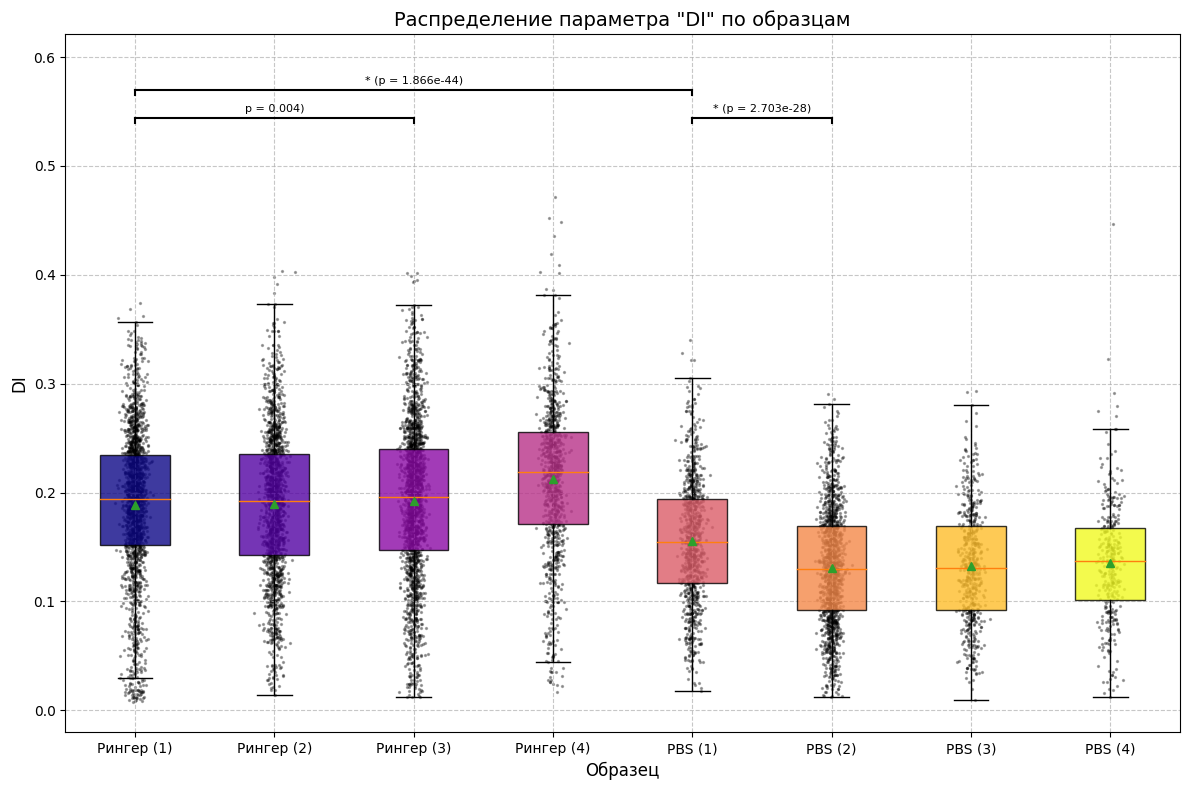

In [82]:
data_traces_pbs_ringer = {}
for i in range(1, 5):
    data_traces_pbs_ringer[f'Рингер ({i})'] = data_traces_ringer[i]
for i in range(1, 5):
    data_traces_pbs_ringer[f'PBS ({i})'] = data_traces_pbs[str(i)]

fig, ax = plot_boxplots_with_ttest_percent(
    data_traces_pbs_ringer,
    'DI',
    pairs_to_compare=[['PBS (1)', 'PBS (2)'], ['Рингер (1)', 'PBS (1)'], ['Рингер (3)', 'Рингер (1)']],
    difference_percent=1,
    sample_names=list(data_traces_pbs_ringer.keys())
)
plt.show()

# Зависимость от количества отмытий

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:35<00:00, 98.80s/it]


                     w1           w2          w3          w4
cell_count   711.000000  1186.000000  735.000000  607.000000
length_mean    9.194826     9.060140    8.963023    8.889822
area_mean     44.479498    49.458994   49.955508   49.995622
EI_mean        1.469153     1.286568    1.252569    1.232691
DI_mean        0.186980     0.123267    0.110184    0.102159
DI_std         0.049473     0.042286    0.041346    0.042193
DI_w           0.122538     0.109753    0.102751    0.097807
DI_BC          0.375865     0.377650    0.340361    0.397425
DI_KC          0.548813     0.565802    0.572857    0.567012


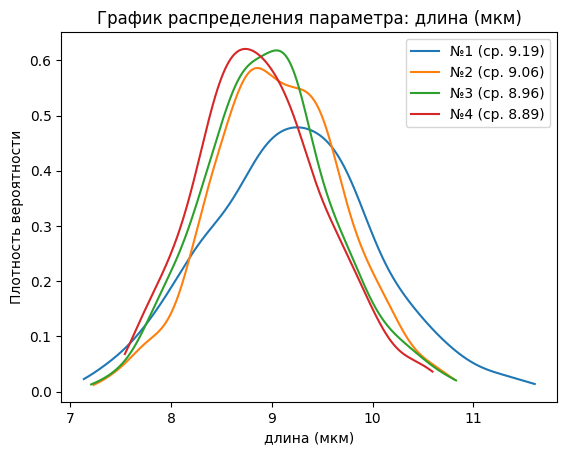

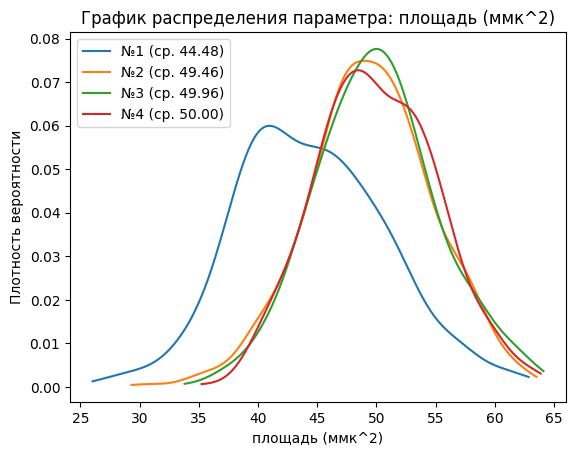

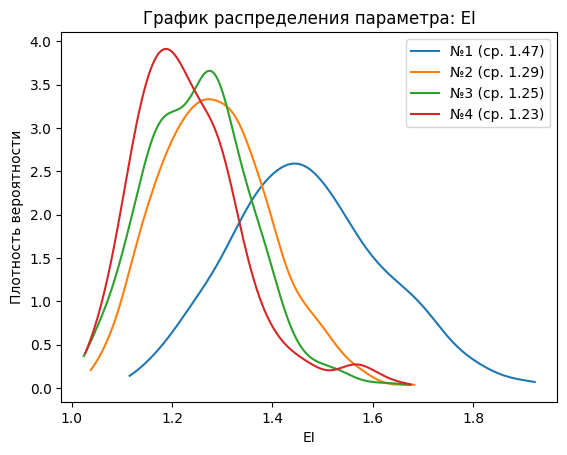

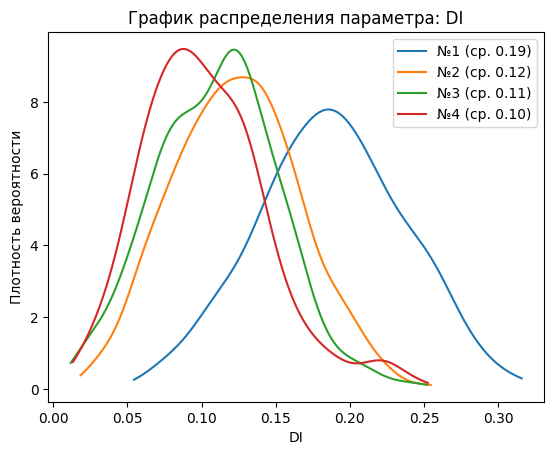

In [75]:
data = {
    "w1" : r"E:\Flow chamber\Ladynin\2025-04-03-flow chamber\w1",
    "w2" : r"E:\Flow chamber\Ladynin\2025-04-03-flow chamber\w2",
    "w3" : r"E:\Flow chamber\Ladynin\2025-04-03-flow chamber\w3",
    "w4" : r"E:\Flow chamber\Ladynin\2025-04-03-flow chamber\w4"
}

database, data_traces_washed = analyse_files(
    data,
    model,
    percent=0.01,
    calculations_name='2025-04-08 all (washed)',
    summary_name='2025-04-08 summary (washed)'
)

draw_graphs(
    data_traces_washed
)

database_washed_pd = pd.DataFrame.from_dict(database)

In [46]:
database_washed_pd = load_traces(r'E:\Flow chamber analysis\2025-04-08 Glytar analysis 5\2025-04-08 all (washed).xlsx')

In [67]:
database_washed_pd = pd.read_excel(r'E:\Flow chamber analysis\2025-04-08 Glytar analysis 5\2025-04-08 summary (washed).xlsx', index_col=0)

In [65]:
database_washed_pd.T

cell_count  length_mean  area_mean   EI_mean   DI_mean    DI_std  \
w1       711.0     9.194826  44.479498  1.469153  0.186980  0.049473   
w2      1186.0     9.060140  49.458994  1.286568  0.123267  0.042286   
w3       735.0     8.963023  49.955508  1.252569  0.110184  0.041346   
w4       607.0     8.889822  49.995622  1.232691  0.102159  0.042193   

        DI_w     DI_BC     DI_KC  
w1  0.122538  0.375865  0.548813  
w2  0.109753  0.377650  0.565802  
w3  0.102751  0.340361  0.572857  
w4  0.097807  0.397425  0.567012

2025-05-23 17:32:02,013 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 17:32:02,022 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


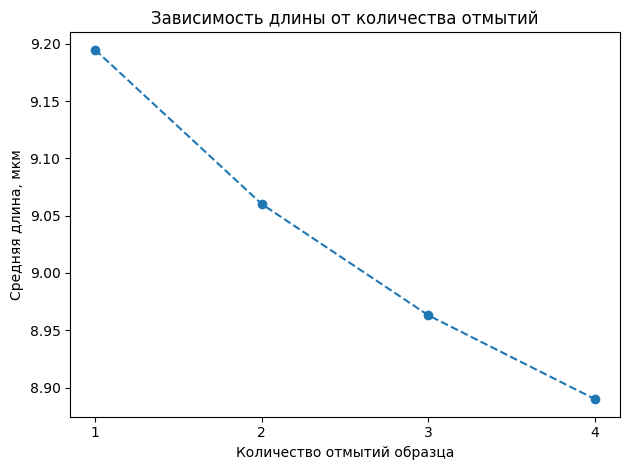

In [69]:
data = {
    "1" : r"E:\Flow chamber\Ladynin\2025-04-03-flow chamber\w1",
    "2" : r"E:\Flow chamber\Ladynin\2025-04-03-flow chamber\w2",
    "3" : r"E:\Flow chamber\Ladynin\2025-04-03-flow chamber\w3",
    "4" : r"E:\Flow chamber\Ladynin\2025-04-03-flow chamber\w4"
}

labels = data.keys()

plt.plot(labels, database_washed_pd.loc["length_mean"], 'o--')
# plt.ylim(bottom=0)
plt.title("Зависимость длины от количества отмытий")
plt.xlabel("Количество отмытий образца")
plt.ylabel("Средняя длина, мкм")
plt.tight_layout()
plt.show()

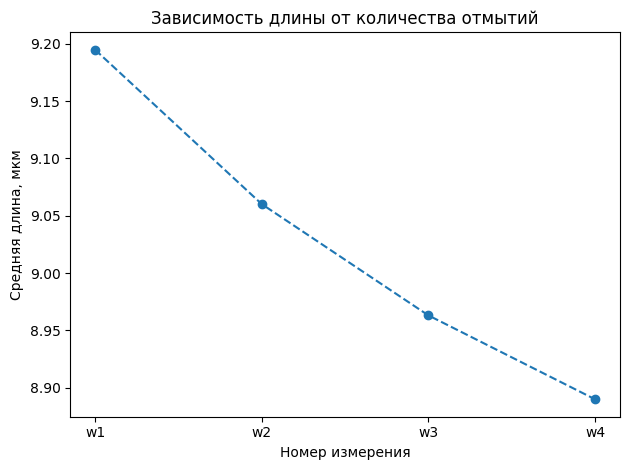

In [89]:
labels = data.keys()

plt.plot(labels, database_washed_pd.loc["length_mean"], 'o--')
# plt.ylim(bottom=0)
plt.title("Зависимость длины от количества отмытий")
plt.xlabel("Номер измерения")
plt.ylabel("Средняя длина, мкм")
plt.tight_layout()
plt.show()

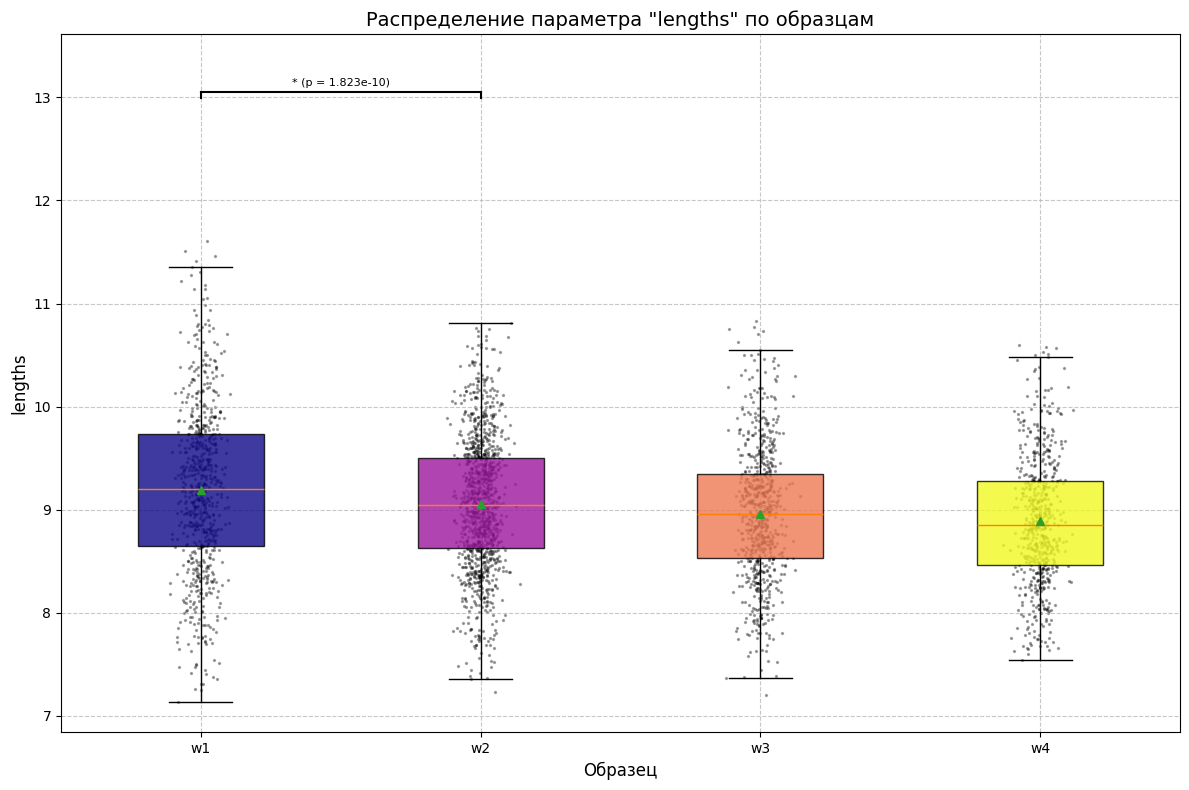

In [86]:
fig, ax = plot_boxplots_with_ttest_percent(
    data_traces_washed,
    'lengths',
    pairs_to_compare=[['w1', 'w2']],
    difference_percent=1,
    sample_names=list(data.keys())
)
plt.show()

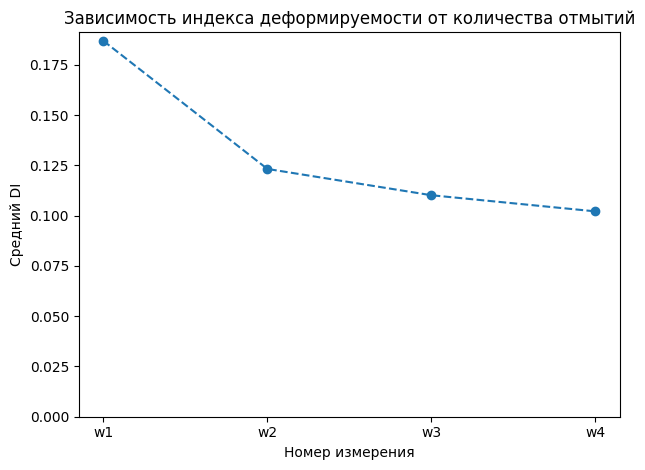

In [90]:
labels = data.keys()

plt.plot(labels, database_washed_pd.loc["DI_mean"], 'o--')
plt.ylim(bottom=0)
plt.title("Зависимость индекса деформируемости от количества отмытий")
plt.xlabel("Номер измерения")
plt.ylabel("Средний DI")
plt.tight_layout()
plt.show()

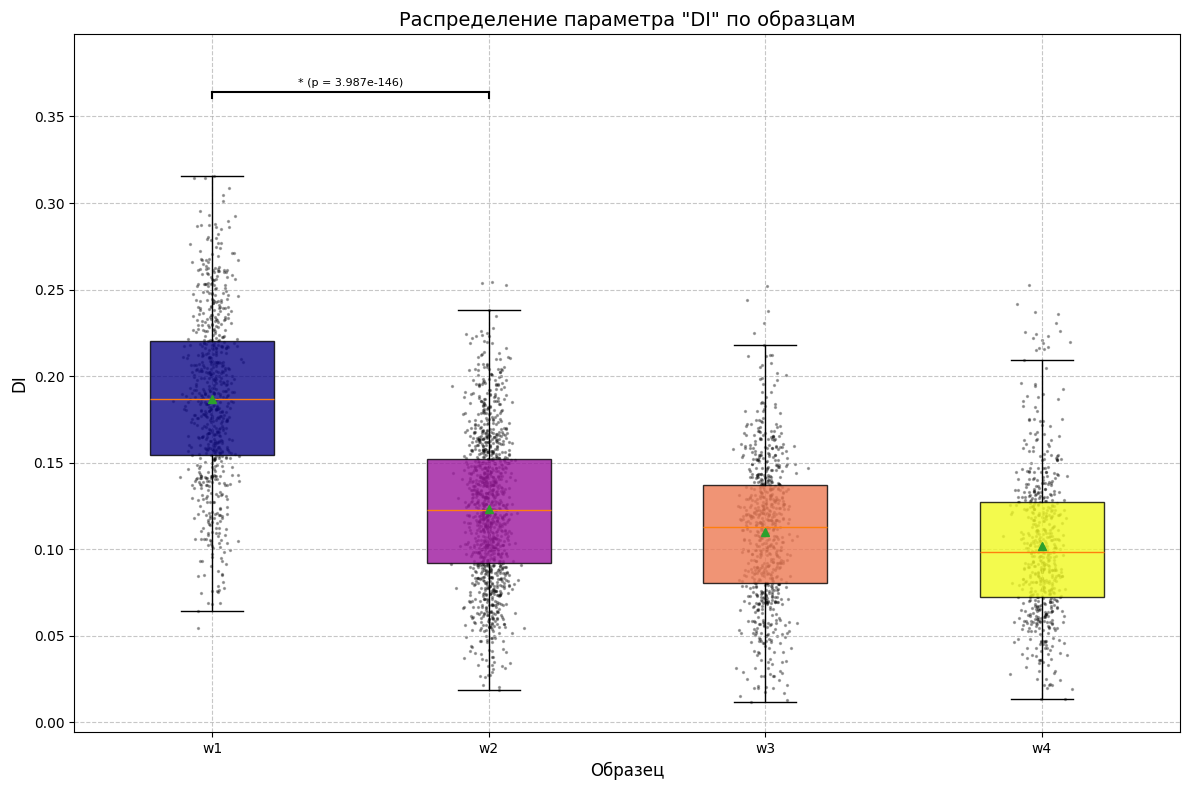

In [93]:
fig, ax = plot_boxplots_with_ttest_percent(
    data_traces_washed,
    'DI',
    pairs_to_compare=[['w1', 'w2']],
    difference_percent=1,
    sample_names=list(data.keys())
)
plt.show()

# Все PBS сразу

In [ ]:
# Зависимость деформируемости от номера измерения я проверял много раз, а именно 4 раза (2 раза себя, 1 раз брата Андрея и пациента)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:05<00:00, 61.48s/it]


                      1           2           3           4
cell_count   967.000000  103.000000  568.000000  227.000000
length_mean    7.438956    8.636982    8.774406    8.831008
area_mean     34.269435   47.471566   48.796520   49.190792
EI_mean        1.263924    1.239929    1.234604    1.236153
DI_mean        0.114403    0.103841    0.102894    0.104295
DI_std         0.043361    0.051455    0.042573    0.034024
DI_w           0.096424    0.087834    0.103508    0.087621
DI_BC          0.374775    0.534465    0.340449    0.338794
DI_KC          0.556169    0.725755    0.555552    0.570725


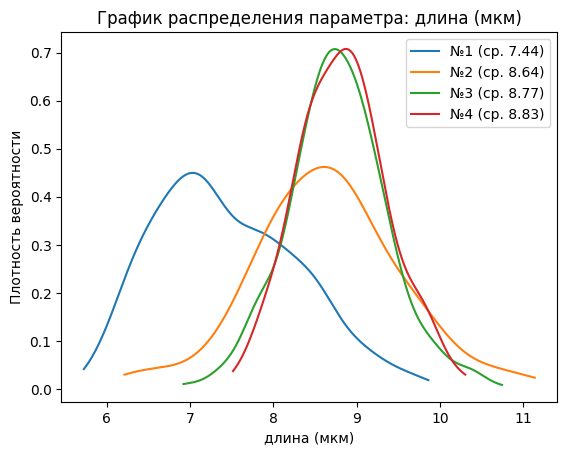

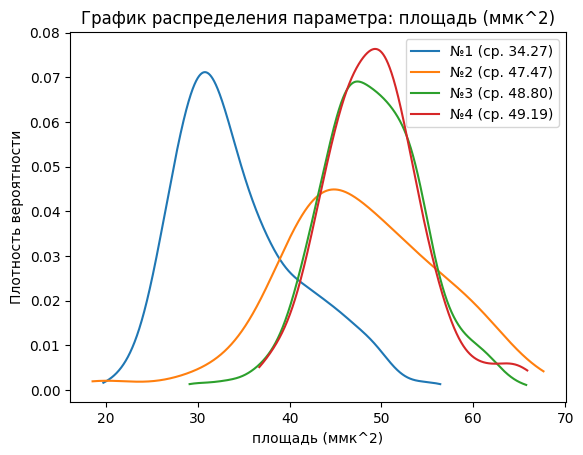

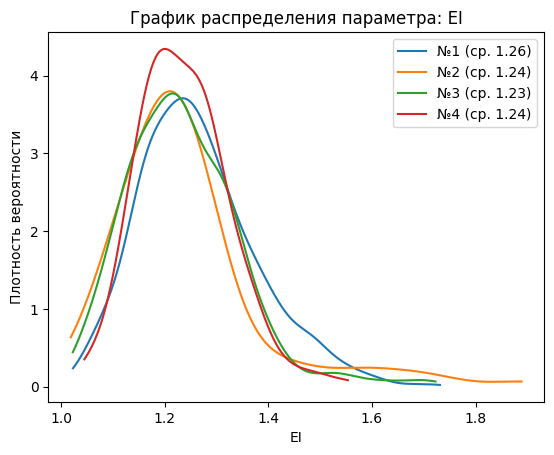

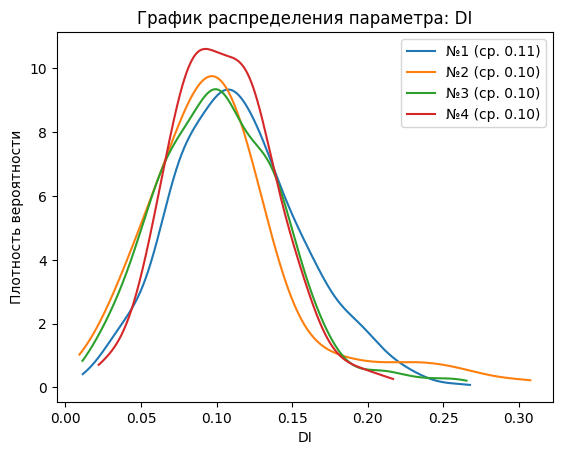

In [94]:
# Пациент Дзагоева
data = {
    "1" : r"E:\Flow chamber\Ladynin\2025-03-26-flow chamber\2\1",
    "2" : r"E:\Flow chamber\Ladynin\2025-03-26-flow chamber\2\2",
    "3" : r"E:\Flow chamber\Ladynin\2025-03-26-flow chamber\2\3",
    "4" : r"E:\Flow chamber\Ladynin\2025-03-26-flow chamber\2\4"
}

database, data_traces_pbs1 = analyse_files(
    data,
    model,
    percent=0.01,
    calculations_name='2025-04-08 all (PBS 1)',
    summary_name='2025-04-08 summary (PBS 1)'
)

draw_graphs(
    data_traces_pbs1
)

database_pbs1_pd = pd.DataFrame.from_dict(database)

In [ ]:
data = {
    "1" : r"E:\Flow chamber\Ladynin\2025-03-26-flow chamber\2\1",
    "2" : r"E:\Flow chamber\Ladynin\2025-03-26-flow chamber\2\2",
    "3" : r"E:\Flow chamber\Ladynin\2025-03-26-flow chamber\2\3",
    "4" : r"E:\Flow chamber\Ladynin\2025-03-26-flow chamber\2\4"
}

load_traces

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:27<00:00, 66.83s/it]


                       1           2            3           4
cell_count   1265.000000  734.000000  1079.000000  888.000000
length_mean     7.742951    8.063166     8.396975    8.616644
area_mean      39.320938   43.503502    46.864573   48.001199
EI_mean         1.199425    1.170962     1.180649    1.210032
DI_mean         0.089108    0.077445     0.080767    0.093336
DI_std          0.037318    0.034339     0.042751    0.038999
DI_w            0.087560    0.088107     0.098797    0.107023
DI_BC           0.398141    0.397182     0.440244    0.386754
DI_KC           0.564743    0.583326     0.570519    0.581970


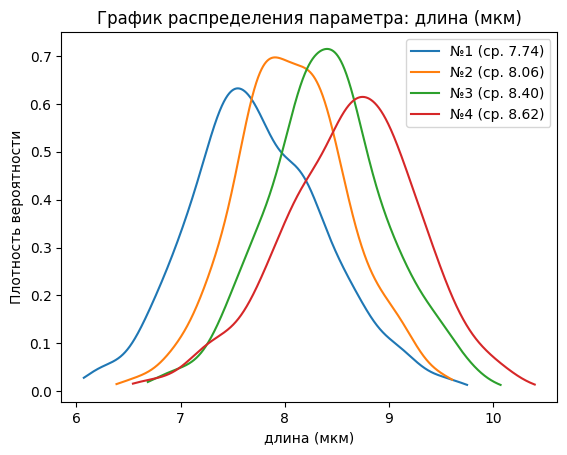

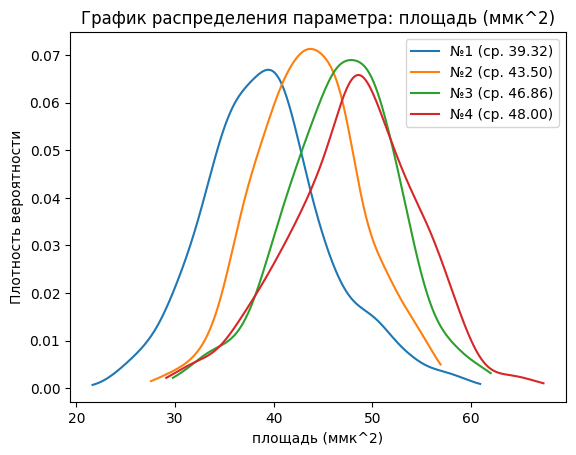

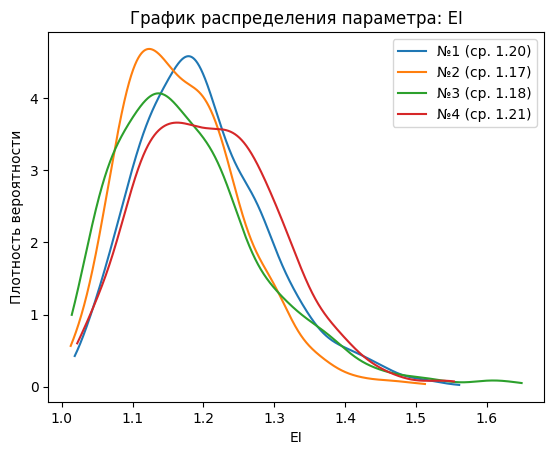

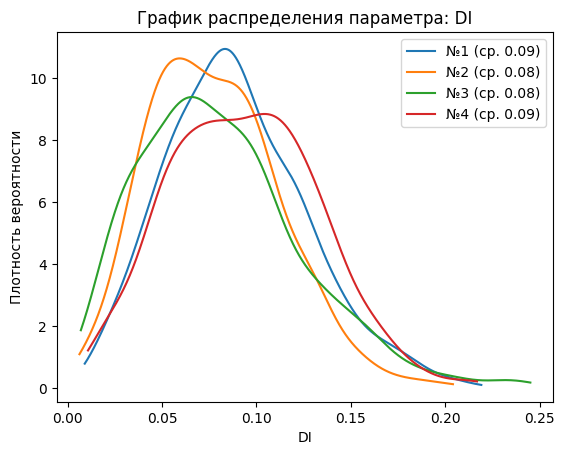

In [95]:
# Мармылев Дмитрий
data = {
    "1" : r"E:\Flow chamber\Ladynin\2025-03-19-flow chamber\4\1",
    "2" : r"E:\Flow chamber\Ladynin\2025-03-19-flow chamber\4\2",
    "3" : r"E:\Flow chamber\Ladynin\2025-03-19-flow chamber\4\3",
    "4" : r"E:\Flow chamber\Ladynin\2025-03-19-flow chamber\4\4"
}

database, data_traces_pbs2 = analyse_files(
    data,
    model,
    percent=0.01,
    calculations_name='2025-04-08 all (PBS 2)',
    summary_name='2025-04-08 summary (PBS 2)'
)

draw_graphs(
    data_traces_pbs2
)

database_pbs2_pd = pd.DataFrame.from_dict(database)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\Users\gorod\anaconda3\envs\cellpose\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 25%|████████████████████▌                                                             | 1/4 [19:42<59:08, 1182.82s/it]C:\Users\gorod\anaconda3\envs\cellpose\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 50%|████████████████████████████████████████                                        | 2/4 [56:59<1:00:05, 1802.61s/it]C:\Users\gorod\anaconda3\envs\cellpose\lib\site-packages\sklearn\

                      1            2            3            4
cell_count   947.000000  1861.000000  1821.000000  1826.000000
length_mean    7.069569     8.081844     8.549377     8.627843
area_mean     31.825134    42.275228    47.159116    47.745121
EI_mean        1.226359     1.209212     1.212095     1.217594
DI_mean        0.099987     0.092531     0.093720     0.096136
DI_std         0.038720     0.043721     0.043613     0.041820
DI_w           0.094477     0.114825     0.108176     0.096863
DI_BC          0.388144     0.394725     0.385467     0.387259
DI_KC          0.568664     0.566576     0.559013     0.558286


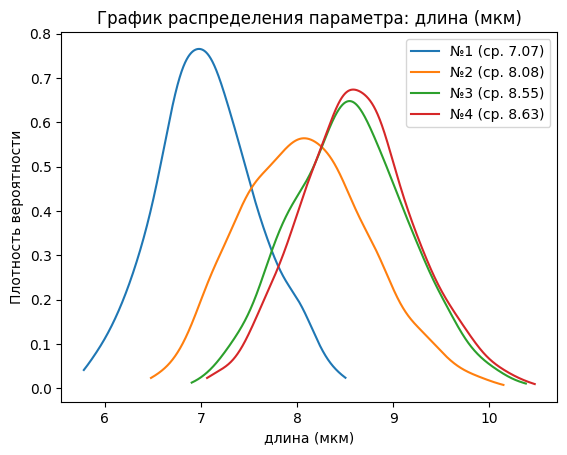

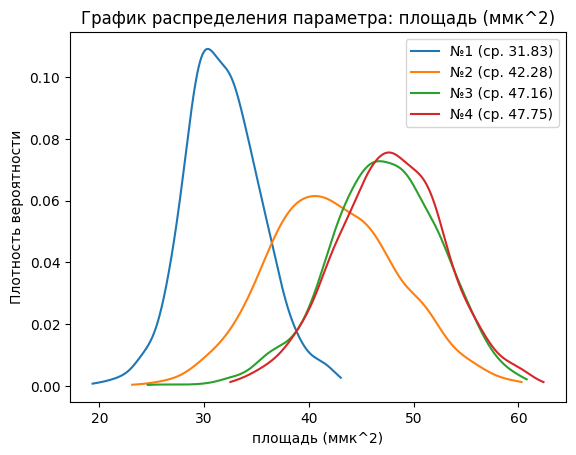

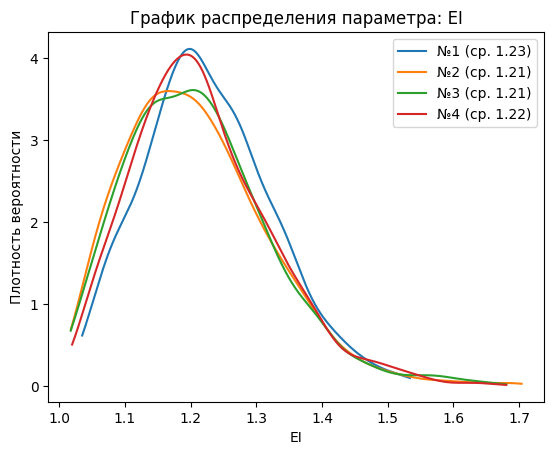

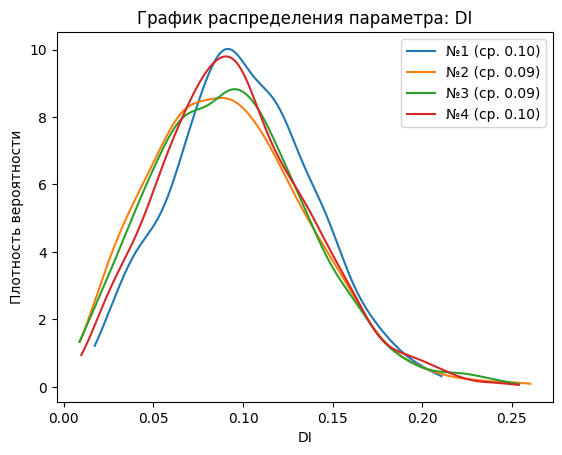

In [15]:
# Второй брат Андрея Мармылева - 
data = {
    "1" : r"E:\Flow chamber\Ladynin\2025-04-03-flow chamber\1",
    "2" : r"E:\Flow chamber\Ladynin\2025-04-03-flow chamber\2",
    "3" : r"E:\Flow chamber\Ladynin\2025-04-03-flow chamber\3",
    "4" : r"E:\Flow chamber\Ladynin\2025-04-03-flow chamber\4"
}

database, data_traces_pbs3 = analyse_files(
    data,
    model,
    percent=0.01,
    calculations_name='2025-04-08 all (PBS 3)',
    summary_name='2025-04-08 summary (PBS 3)'
)

draw_graphs(
    data_traces_pbs3
)

database_pbs3_pd = pd.DataFrame.from_dict(database)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\Users\gorod\anaconda3\envs\cellpose\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 25%|████████████████████                                                            | 1/4 [38:48<1:56:25, 2328.52s/it]C:\Users\gorod\anaconda3\envs\cellpose\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 50%|███████████████████████████████████████                                       | 2/4 [1:25:01<1:26:19, 2589.79s/it]C:\Users\gorod\anaconda3\envs\cellpose\lib\site-packages\sklearn\

                       1            2            3            4
cell_count   2733.000000  2495.000000  1210.000000  1393.000000
length_mean     7.556219     9.007233     9.198473     9.081078
area_mean      33.522348    46.174543    46.508300    46.449452
EI_mean         1.333047     1.371627     1.412329     1.385874
DI_mean         0.139049     0.151914     0.166628     0.157189
DI_std          0.056008     0.062244     0.058749     0.060632
DI_w            0.149738     0.141286     0.141387     0.139815
DI_BC           0.382622     0.385555     0.355372     0.370665
DI_KC           0.566925     0.552296     0.560825     0.552089


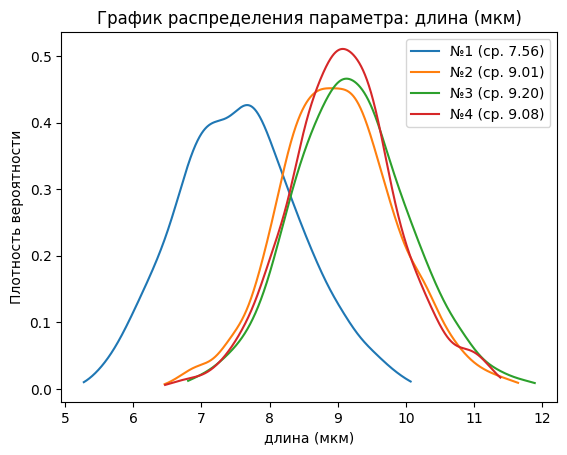

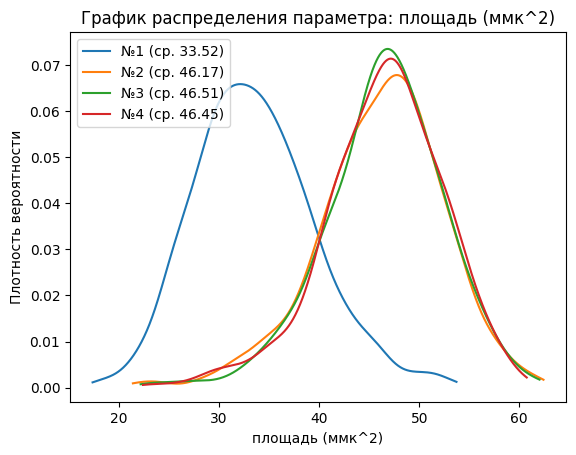

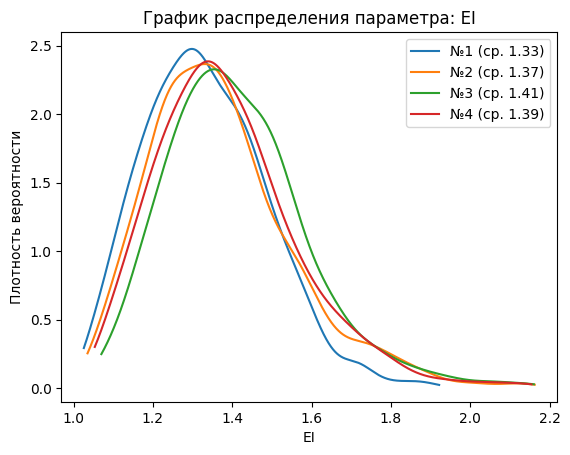

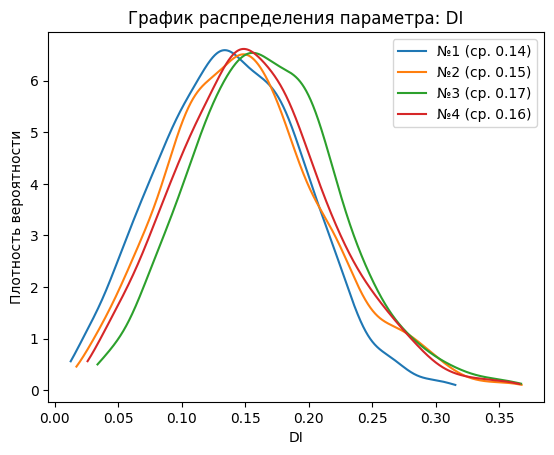

In [16]:
# Ладынин 3
data = {
    "1" : r"E:\Flow chamber\Ladynin\2025-01-31-flow chamber\1",
    "2" : r"E:\Flow chamber\Ladynin\2025-01-31-flow chamber\2",
    "3" : r"E:\Flow chamber\Ladynin\2025-01-31-flow chamber\3",
    "4" : r"E:\Flow chamber\Ladynin\2025-01-31-flow chamber\4"
}

database, data_traces_pbs4 = analyse_files(
    data,
    model,
    percent=0.01,
    calculations_name='2025-04-08 all (PBS 4)',
    summary_name='2025-04-08 summary (PBS 4)'
)

draw_graphs(
    data_traces_pbs4
)

database_pbs4_pd = pd.DataFrame.from_dict(database)

In [5]:
database_pbs_pd = pd.read_excel(r'E:\Flow chamber analysis\2025-04-08 Glytar analysis 5\2025-04-08 summary (PBS).xlsx', index_col=0)
database_pbs1_pd = pd.read_excel(r'E:\Flow chamber analysis\2025-04-08 Glytar analysis 5\2025-04-08 summary (PBS 1).xlsx', index_col=0)
database_pbs2_pd = pd.read_excel(r'E:\Flow chamber analysis\2025-04-08 Glytar analysis 5\2025-04-08 summary (PBS 2).xlsx', index_col=0)
database_pbs3_pd = pd.read_excel(r'E:\Flow chamber analysis\2025-04-08 Glytar analysis 5\2025-04-08 summary (PBS 3).xlsx', index_col=0)
database_pbs4_pd = pd.read_excel(r'E:\Flow chamber analysis\2025-04-08 Glytar analysis 5\2025-04-08 summary (PBS 4).xlsx', index_col=0)

2025-05-23 16:21:40,782 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 16:21:40,787 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 16:21:40,792 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 16:21:40,795 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 16:21:40,799 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or 

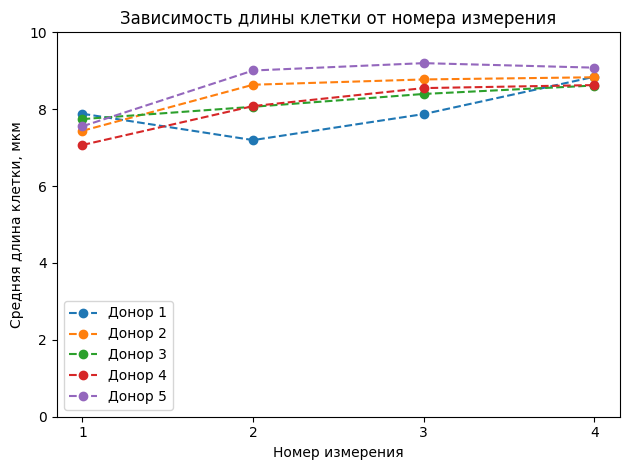

In [8]:
data = {
    "1" : r"E:\Flow chamber\Ladynin\2025-03-26-flow chamber\2\1",
    "2" : r"E:\Flow chamber\Ladynin\2025-03-26-flow chamber\2\2",
    "3" : r"E:\Flow chamber\Ladynin\2025-03-26-flow chamber\2\3",
    "4" : r"E:\Flow chamber\Ladynin\2025-03-26-flow chamber\2\4"
}

labels = data.keys()

plt.plot(labels, database_pbs_pd.loc["length_mean"], 'o--')
plt.plot(labels, database_pbs1_pd.loc["length_mean"], 'o--')
plt.plot(labels, database_pbs2_pd.loc["length_mean"], 'o--')
plt.plot(labels, database_pbs3_pd.loc["length_mean"], 'o--')
plt.plot(labels, database_pbs4_pd.loc["length_mean"], 'o--')
plt.ylim(bottom=0, top=10)
plt.title("Зависимость длины клетки от номера измерения")
plt.xlabel("Номер измерения")
plt.ylabel("Средняя длина клетки, мкм")
plt.tight_layout()
plt.legend(['Донор 1', 'Донор 2', 'Донор 3', 'Донор 4', 'Донор 5'])
plt.show()

2025-05-23 16:54:51,695 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 16:54:51,701 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 16:54:51,705 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 16:54:51,711 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-23 16:54:51,773 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or 

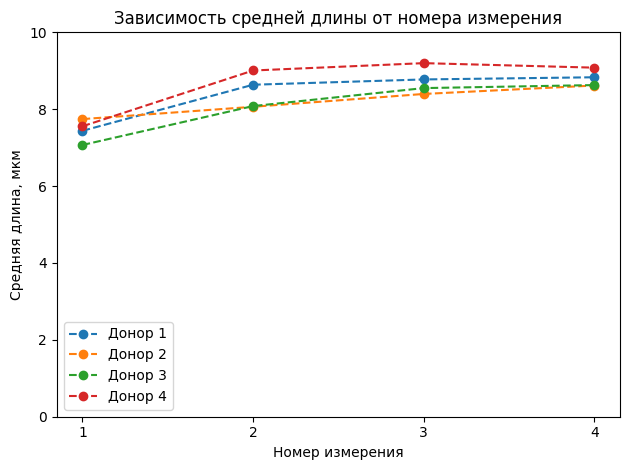

In [14]:
labels = data.keys()

# plt.plot(labels, database_pbs_pd.loc["length_mean"], 'o--')
plt.plot(labels, database_pbs1_pd.loc["length_mean"], 'o--')
plt.plot(labels, database_pbs2_pd.loc["length_mean"], 'o--')
plt.plot(labels, database_pbs3_pd.loc["length_mean"], 'o--')
plt.plot(labels, database_pbs4_pd.loc["length_mean"], 'o--')
plt.ylim(bottom=0, top=10)
plt.title("Зависимость средней длины от номера измерения")
plt.xlabel("Номер измерения")
plt.ylabel("Средняя длина, мкм")
plt.tight_layout()
plt.legend(['Донор 1', 'Донор 2', 'Донор 3', 'Донор 4'])
plt.show()

In [10]:
labels = data.keys()

plt.plot(labels, database_pbs_pd.loc["length_mean"], 'o--')
plt.plot(labels, database_pbs1_pd.loc["length_mean"], 'o--')
plt.plot(labels, database_pbs2_pd.loc["length_mean"], 'o--')
plt.plot(labels, database_pbs3_pd.loc["length_mean"], 'o--')
plt.plot(labels, database_pbs4_pd.loc["length_mean"], 'o--')
# plt.ylim(bottom=0)
plt.title("Зависимость длины клетки от номера измерения")
plt.xlabel("Номер измерения")
plt.ylabel("Длина клетки, мкм")
plt.tight_layout()
plt.legend(['PBS 1 (Ладынин)', 'PBS 2 (Дзагоева)', 'PBS 3 (Мармылев Д.)', 'PBS 4 (Елисеев)', 'PBS 5 (Ладынин)'])
plt.show()

NameError: name 'database_pbs_pd' is not defined

2025-04-09 21:22:00,185 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-09 21:22:00,210 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-09 21:22:00,214 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-09 21:22:00,237 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-09 21:22:00,244 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or 

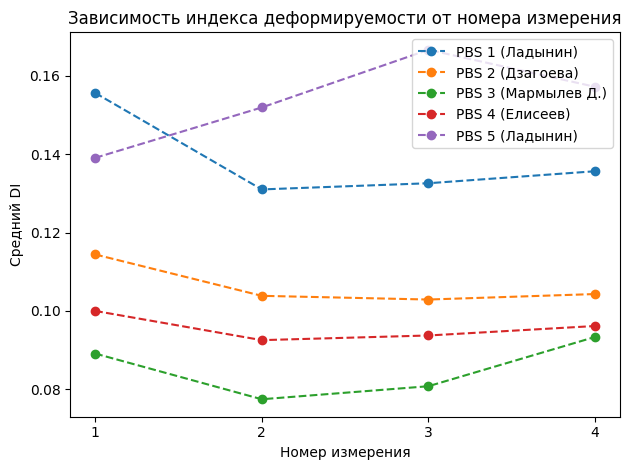

In [105]:
labels = data.keys()

plt.plot(labels, database_pbs_pd.loc["DI_mean"], 'o--')
plt.plot(labels, database_pbs1_pd.loc["DI_mean"], 'o--')
plt.plot(labels, database_pbs2_pd.loc["DI_mean"], 'o--')
plt.plot(labels, database_pbs3_pd.loc["DI_mean"], 'o--')
plt.plot(labels, database_pbs4_pd.loc["DI_mean"], 'o--')
# plt.ylim(bottom=0)
plt.title("Зависимость индекса деформируемости от номера измерения")
plt.xlabel("Номер измерения")
plt.ylabel("Средний DI")
plt.tight_layout()
plt.legend(['PBS 1 (Ладынин)', 'PBS 2 (Дзагоева)', 'PBS 3 (Мармылев Д.)', 'PBS 4 (Елисеев)', 'PBS 5 (Ладынин)'])
plt.show()